## House Price Prediction using AI

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

In [95]:
data = pd.read_csv('house_prices.csv')
data.sample(2).T

178772  \
Index                                                         178772   
Title              2 BHK Ready to Occupy Flat for sale Astha Resi...   
Description        This attractive 2 BHK apartment can be found f...   
Amount(in rupees)                                          49.5 Lac    
Price (in rupees)                                             3773.0   
location                                                       surat   
Carpet Area                                                 800 sqft   
Status                                                 Ready to Move   
Floor                                                     2 out of 5   
Transaction                                                   Resale   
Furnishing                                               Unfurnished   
facing                                                           NaN   
overlooking                                   Garden/Park, Main Road   
Society                                                          NaN   
Bathroom                                                           2   
Balcony                                                            2   
Car Parking                                                      NaN   
Ownership                                                        NaN   
Super Area                                                       NaN   
Dimensions                                                       NaN   
Plot Area                                                        NaN   

                                                              41373   
Index                                                          41373  
Title               1 BHK Ready to Occupy Flat for sale Guduvancheri  
Description        This beautiful 1 BHK Flat is available for sal...  
Amount(in rupees)                                            24 Lac   
Price (in rupees)                                             4000.0  
location                                                     chennai  
Carpet Area                                                      NaN  
Status                                                 Ready to Move  
Floor                                                Ground out of 3  
Transaction                                                   Resale  
Furnishing                                               Unfurnished  
facing                                                          East  
overlooking                                                      NaN  
Society                                                          NaN  
Bathroom                                                           1  
Balcony                                                            1  
Car Parking                                                      NaN  
Ownership                                                   Freehold  
Super Area                                                  600 sqft  
Dimensions                                                       NaN  
Plot Area                                                        NaN

In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187531 entries, 0 to 187530
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Index              187531 non-null  int64  
 1   Title              187531 non-null  object 
 2   Description        184508 non-null  object 
 3   Amount(in rupees)  187531 non-null  object 
 4   Price (in rupees)  169866 non-null  float64
 5   location           187531 non-null  object 
 6   Carpet Area        106858 non-null  object 
 7   Status             186916 non-null  object 
 8   Floor              180454 non-null  object 
 9   Transaction        187448 non-null  object 
 10  Furnishing         184634 non-null  object 
 11  facing             117298 non-null  object 
 12  overlooking        106095 non-null  object 
 13  Society            77853 non-null   object 
 14  Bathroom           186703 non-null  object 
 15  Balcony            138596 non-null  object 
 16  Ca

In [97]:
data.nunique()

Index                187531
Title                 32446
Description           65634
Amount(in rupees)      1561
Price (in rupees)     10958
location                 81
Carpet Area            2758
Status                    1
Floor                   947
Transaction               4
Furnishing                3
facing                    8
overlooking              19
Society               10376
Bathroom                 11
Balcony                  11
Car Parking             229
Ownership                 4
Super Area             2976
Dimensions                0
Plot Area                 0
dtype: int64

### 1. Data Preprocessing

In this section, we will focus on preparing our data for analysis. Effective data preprocessing is crucial for ensuring that our data is clean and ready for machine learning algorithms.


#### **1.1 Transforming Textual Data into Numerical Representations**

Textual data often needs to be converted into numerical representations for analysis. We will explore techniques for doing this for specific features in our dataset.

In [98]:
data[['Price', 'Price Units']] = data['Amount(in rupees)'].str.split(' ', n = 1, expand=True)
data['Price Units'].value_counts()

Lac          112568
Cr            65279
for Price      9684
Name: Price Units, dtype: int64

Function `convert_price` transform real estate property prices in the format of "Lac" and "Cr" into numerical values in rupees. It then applies this function to a DataFrame column 'Amount(in rupees)' to create a new column `Price`

In [99]:
def convert_price(price):
    if 'Lac' in price:
        return float(price.split(' ')[0]) * 100000
    elif 'Cr' in price:
        return float(price.split(' ')[0]) * 10000000
    else:
        # print(price)
        return np.nan

data['Price'] = data['Amount(in rupees)'].apply(convert_price)
data[['Amount(in rupees)', 'Price']].sample(5)

Amount(in rupees)       Price
13178            56 Lac    5600000.0
2998            1.40 Cr   14000000.0
116759           60 Lac    6000000.0
162896         29.5 Lac    2950000.0
47146            53 Lac    5300000.0

In [100]:
data.drop(['Amount(in rupees)', 'Price Units'], axis=1, inplace=True)

In [101]:
def get_current_floor(floor_rec):
    # print('Current Floor')
    # print(floor_rec)
    if str(floor_rec) == 'nan':
        return np.nan
    floor = floor_rec.split(' ')

    # if not floor[0].isdigit() and floor[0] != 'Ground':
    #     print(floor_rec)

    if floor[0] == 'Lower':
        return -1
    if floor[0] == 'Upper':
        return -2
    if floor[0] == 'Ground':
        return 0
    elif floor[0] == 'Total':
        return float(floor[-1])
    else:
        return float(floor[0])

def get_total_floor(floor_rec):
    # print('Total Floors')
    # print(floor_rec)
    if str(floor_rec) == 'nan':
        return np.nan
    floor = floor_rec.split(' ')
    if floor[0] in ['Ground', 'Lower', 'Upper']:
        return np.nan
    return float(floor[-1])


# Extract current floor and total floors
data['Current_Floor'] = data['Floor'].apply(get_current_floor)

# Calculate the "Total_Floors" using a lambda function and 'Ground' as NaN
data['Total_Floors'] = data['Floor'].apply(get_total_floor)
data['Current_Floor'].fillna(data['Current_Floor'].mode()[0], inplace=True)
data['Total_Floors'].fillna(data['Total_Floors'].mode()[0], inplace=True)
data['Floor_Percentage'] = round(data['Current_Floor'] / data['Total_Floors']*100, 0)
data[['Floor', 'Current_Floor', 'Total_Floors', 'Floor_Percentage']].sample(5)

Floor  Current_Floor  Total_Floors  Floor_Percentage
49715                NaN            2.0           4.0              50.0
26364   Ground out of 10            0.0           4.0               0.0
89049         4 out of 4            4.0           4.0             100.0
47881         2 out of 2            2.0           2.0             100.0
113100        4 out of 4            4.0           4.0             100.0

In [102]:
data[data.Floor_Percentage > 0][['Floor', 'Current_Floor', 'Total_Floors', 'Floor_Percentage']].sample(5)

Floor  Current_Floor  Total_Floors  Floor_Percentage
156309    1 out of 4            1.0           4.0              25.0
32490     3 out of 6            3.0           6.0              50.0
93207   17 out of 20           17.0          20.0              85.0
68581   11 out of 22           11.0          22.0              50.0
183941    3 out of 5            3.0           5.0              60.0

In [103]:
data[data.Floor_Percentage > 100].shape

(6, 24)

In [104]:
data = data[data['Floor_Percentage'] <= 100]
data[data.Floor_Percentage > 100].shape

(0, 24)

In [105]:
data.drop(['Floor'], inplace=True, axis=1)

In [106]:
data.overlooking.value_counts()

Main Road                                      32193
Garden/Park, Main Road                         27238
Garden/Park                                    23077
Garden/Park, Pool, Main Road                   12413
Pool, Garden/Park, Main Road                    3615
Garden/Park, Pool                               2880
Main Road, Garden/Park, Pool                    1359
Pool, Main Road                                 1136
Pool                                            1012
Main Road, Garden/Park                           666
Pool, Garden/Park                                435
Garden/Park, Main Road, Pool                      39
Main Road, Pool                                   11
Main Road, Pool, Garden/Park                       8
Pool, Main Road, Garden/Park                       6
Main Road, Not Available                           4
Garden/Park, Pool, Main Road, Not Available        1
Garden/Park, Not Available                         1
Pool, Main Road, Not Available                

Binary features were generated using an `create_binary_columns` to categorize properties based on their overlooking attributes. The function converted complex overlooking descriptions into binary values (0 or 1) for attributes like `Main Road`, `Garden/Park`, `Pool`, and `Not Available`. This transformation simplified data analysis, resulting in a concise representation of each property's overlooking characteristics.

In [107]:
def create_binary_columns(record, attributes):
    if str(record) == 'nan':
        return 0
    records = record.split(', ')
    for attribute in attributes:
        if attribute in records:
            return 1
    return 0

# Define the list of attributes
attributes = ['Main Road', 'Garden/Park', 'Pool', 'Not Available']

# Apply the function to create binary columns for each attribute
for attribute in attributes:
    data[attribute] = data.overlooking.apply(lambda x: create_binary_columns(x, [attribute]))

data[['overlooking'] + attributes].sample(5)

overlooking  Main Road  Garden/Park  Pool  Not Available
140589               Main Road          1            0     0              0
52531                      NaN          0            0     0              0
78540                      NaN          0            0     0              0
136601  Garden/Park, Main Road          1            1     0              0
11177                      NaN          0            0     0              0

In [108]:
data.drop(['overlooking'], axis=1, inplace=True)

<Axes: >

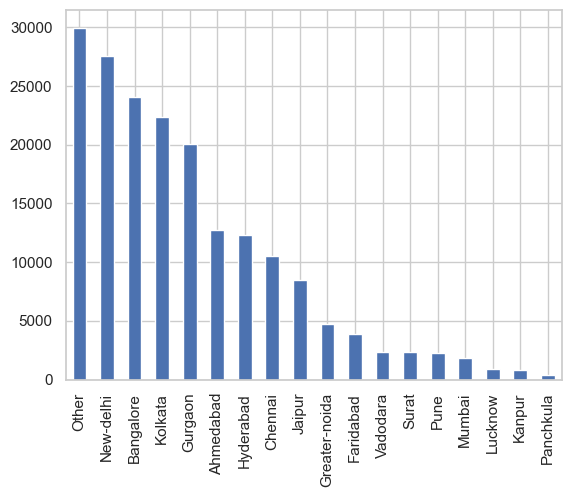

In [109]:
# List of categories to keep
keep_categories = [
    'pune', 'lucknow', 'kanpur', 'new-delhi', 'bangalore', 'kolkata', 
    'gurgaon', 'ahmedabad', 'hyderabad', 'chennai', 'jaipur', 
    'greater-noida', 'faridabad', 'vadodara', 'surat', 'mumbai', 'panchkula'
]

# Function to categorize locations
def categorize_location(loc):
    if loc.strip().lower() in keep_categories:
        return loc.strip().capitalize()
    else:
        return 'Other'

# Apply the function to the 'location' column
data['location_category'] = data['location'].apply(categorize_location)

# Check the result
data[['location', 'location_category']].head()

# Checking the new distribution of the 'location_grouped' column
location_grouped_analysis = data['location_category'].value_counts()
location_grouped_analysis.plot(kind='bar')


In [110]:
# Dropping records having number of bathrooms and Balconies greater than 10 so it can be converted to numberic from category

data = data[data['Bathroom'] != '> 10']
data = data[data['Balcony'] != '> 10']

In [111]:
data['Car Parking'].fillna('Unknown', inplace=True)
data['Parking Count'] = data['Car Parking'].str.extract('(\d+)').astype(float)
data['Parking Count'].fillna(0, inplace=True)
data['Parking Type'] = data['Car Parking'].str.extract('([A-Za-z ]+)')
data.drop(columns=['Car Parking'], inplace=True)

In [112]:
data.sample(2)

Index                                              Title  \
120313  120313  3 BHK Ready to Occupy Flat for sale in Him Hit...   
16892    16892        2 BHK Ready to Occupy Flat for sale Kengeri   

                                              Description  Price (in rupees)  \
120313  This gorgeous 3 BHK Flat is available for sale...            10500.0   
16892   Creatively planned and constructed is a 2 BHK ...             3898.0   

         location Carpet Area         Status Transaction      Furnishing  \
120313  new-delhi   1500 sqft  Ready to Move      Resale       Furnished   
16892   bangalore         NaN  Ready to Move      Resale  Semi-Furnished   

       facing  ... Current_Floor Total_Floors Floor_Percentage Main Road  \
120313   East  ...           4.0          8.0             50.0         1   
16892     NaN  ...           1.0          4.0             25.0         0   

       Garden/Park  Pool  Not Available  location_category  Parking Count  \
120313           1     0              0          New-delhi            2.0   
16892            0     0              0          Bangalore            1.0   

        Parking Type  
120313          Open  
16892        Covered  

[2 rows x 28 columns]

In [113]:
correlation = data['Price'].corr(data['Parking Count'])
print(f'Correlation between Price and Available: {correlation:.2f}')

Correlation between Price and Available: -0.00


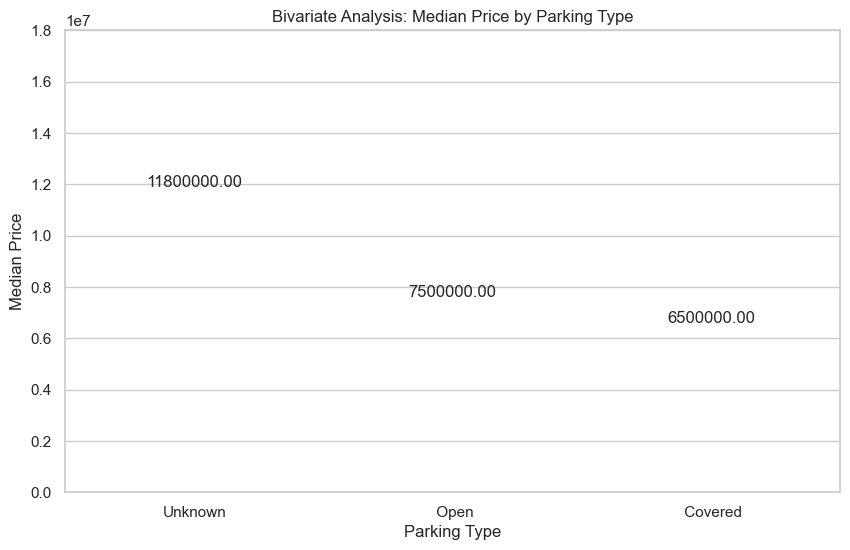

In [114]:
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='Parking Type', y='Price', palette='viridis', estimator=np.median, ci=None)
plt.title('Bivariate Analysis: Median Price by Parking Type')
plt.xlabel('Parking Type')
plt.ylabel('Median Price')

# Adjust the y-axis limits to better visualize the median values
plt.ylim(0, 18000000)

# Annotate median values on the bars
medians = data.groupby('Parking Type')['Price'].median().values
for i, median in enumerate(medians):
    plt.text(i, median, f'{median:.2f}', ha='center', va='bottom', fontsize=12)

plt.show()

In [115]:
def extract_numeric_value(text):
    try:
        numeric_part = text.split(' ')[0]
        return int(numeric_part)
    except:
        return np.nan

# Apply the function to the "Carpet_Area" column
data['Carpet Area'] = data['Carpet Area'].apply(extract_numeric_value)

# 1.2 Missing Data Handling

Dealing with missing data is a critical step in data preprocessing. We will employ several strategies to address missing values:
Columns Drop:Removing entire columns with excessive missing data.
Rows Drop: Eliminating rows with more than 5 missing values.
Fill Null with Mean, Mode, and Median: Replacing missing values with statistical measures.
Creating a New Category for Unknown Fields:Handling missing categorical data by introducing a new category.

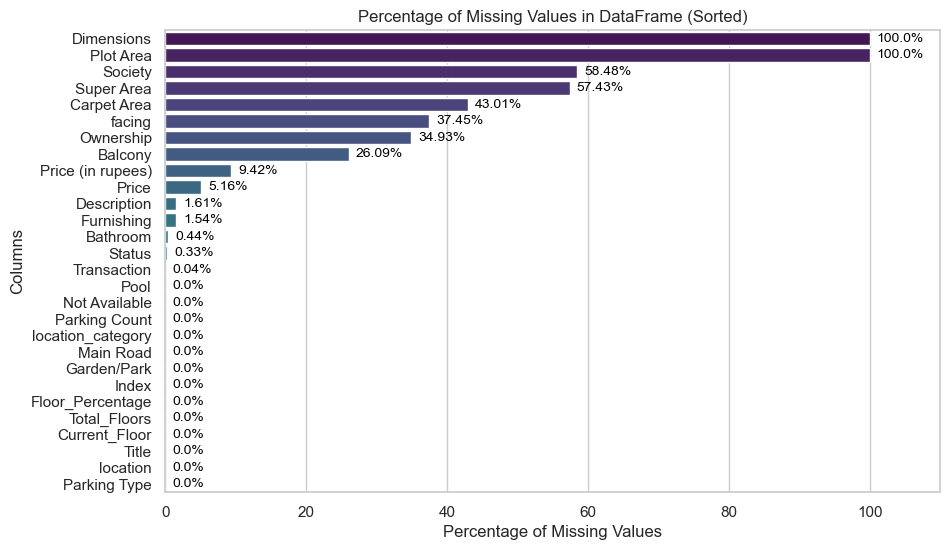

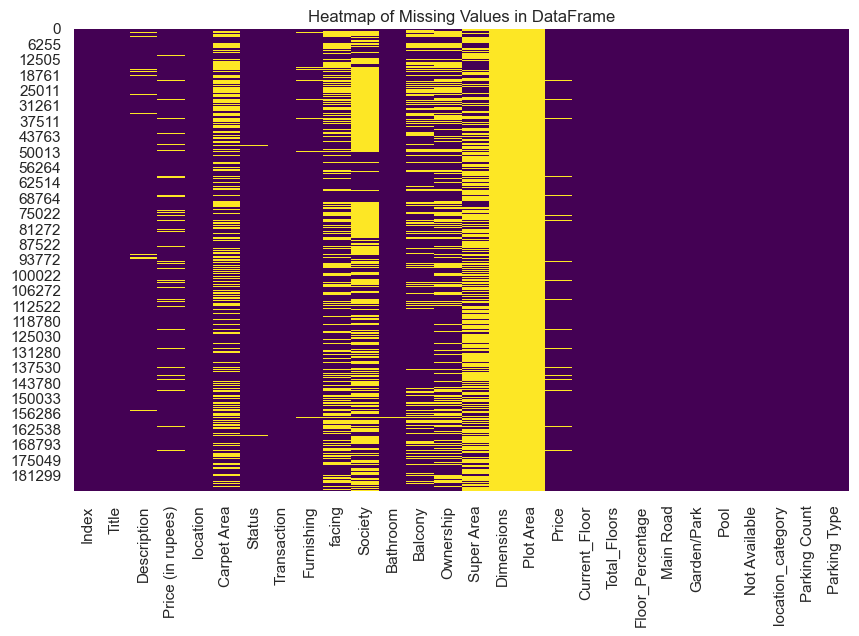

In [116]:
def visualize_missing_data(data):
    null_percentage = (data.isnull().mean() * 100).round(2).sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=null_percentage, y=null_percentage.index, palette='viridis')
    plt.xlabel('Percentage of Missing Values')
    plt.ylabel('Columns')
    plt.title('Percentage of Missing Values in DataFrame (Sorted)')
    for p in ax.patches:
        width = p.get_width()
        plt.text(width + 1, p.get_y() + p.get_height() / 2,
                 f'{width}%', ha='left', va='center', fontsize=10, color='black')
    plt.xlim(0, 110)
    plt.show()
    plt.figure(figsize=(10, 6))
    sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
    plt.title('Heatmap of Missing Values in DataFrame')
    plt.show()

# Call the function with your DataFrame
visualize_missing_data(data)


In [117]:
# Columns Drop: Removing entire columns with excessive missing data and un necessary columns
data.drop(['Title', 'Description', 'Dimensions', 'Plot Area','Society', 'Index', 'Super Area', 'Current_Floor', 'Total_Floors', 'location', 'Status', 'Price (in rupees)'], axis=1, inplace=True)
data.sample(5)

Carpet Area   Transaction      Furnishing        facing Bathroom  \
185436       1200.0        Resale     Unfurnished          East        2   
103046        561.0        Resale  Semi-Furnished          East        1   
50347        2600.0  New Property  Semi-Furnished  North - East        4   
164368       1050.0        Resale  Semi-Furnished         South        2   
18521           NaN        Resale     Unfurnished           NaN        2   

       Balcony  Ownership       Price  Floor_Percentage  Main Road  \
185436       1   Freehold   3000000.0              80.0          1   
103046       1   Freehold         NaN             100.0          1   
50347        2   Freehold  28400000.0              25.0          1   
164368       3  Leasehold   4600000.0              56.0          1   
18521        1        NaN   7000000.0              40.0          0   

        Garden/Park  Pool  Not Available location_category  Parking Count  \
185436            0     0              0             Other            0.0   
103046            1     0              0           Kolkata            0.0   
50347             1     0              0           Gurgaon            0.0   
164368            1     0              0     Greater-noida            1.0   
18521             0     0              0         Bangalore            0.0   

       Parking Type  
185436      Unknown  
103046      Unknown  
50347       Unknown  
164368      Covered  
18521       Unknown

In [118]:
# Dropping rows where there is no Price information
data.dropna(subset=['Price'], inplace=True)

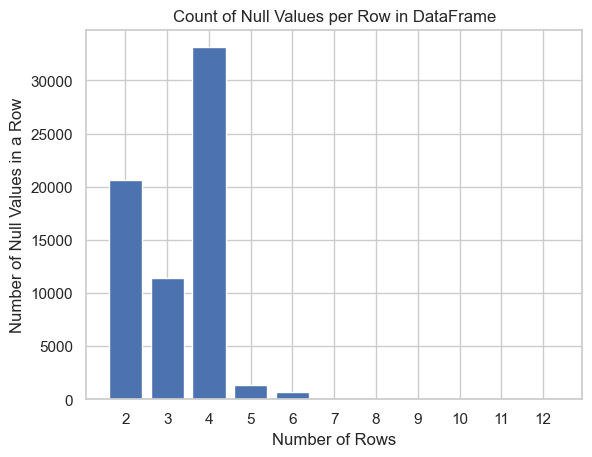

In [119]:
def count_nulls_by_column_range(data, min_cols, max_cols):
    counts = {}
    for i in range(min_cols, max_cols + 1):
        count = data[data.isnull().sum(axis=1) == i].shape[0]
        counts[i] = count
    return counts

# Counting nulls from 2 to 12 columns
null_counts = count_nulls_by_column_range(data, 2, 12)

# Plotting the results
plt.bar(null_counts.keys(), null_counts.values())
plt.ylabel('Number of Null Values in a Row')
plt.xlabel('Number of Rows')
plt.title('Count of Null Values per Row in DataFrame')
plt.xticks(range(2, 13))  # Adjusting x-ticks for better readability
plt.show()

In [120]:
# Dropping rows where the count of null values is greater than 4
data_dropped = data[data.isnull().sum(axis=1) <= 4]

print(data_dropped.shape, data.shape)  # Showing the shape of the DataFrame before and after dropping rows
data = data_dropped

(175785, 16) (177808, 16)


In [121]:
visualize_missing_data(data)

In [122]:
columns_to_impute = ['Transaction', 'Furnishing', 'Bathroom', 'Balcony']

# Loop through the columns and impute missing values with the mode
for column in columns_to_impute:
    mode_value = data[column].mode()[0]
    data[column].fillna(mode_value, inplace=True)

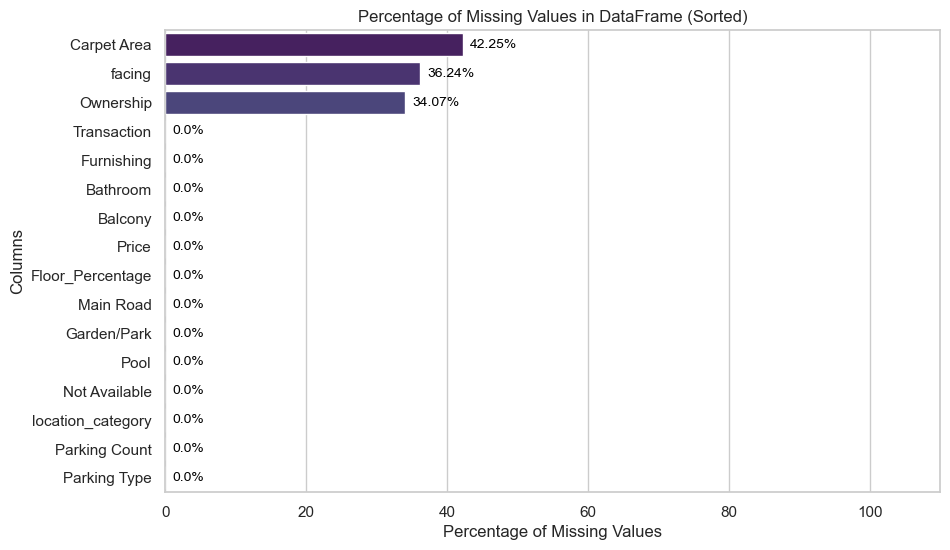

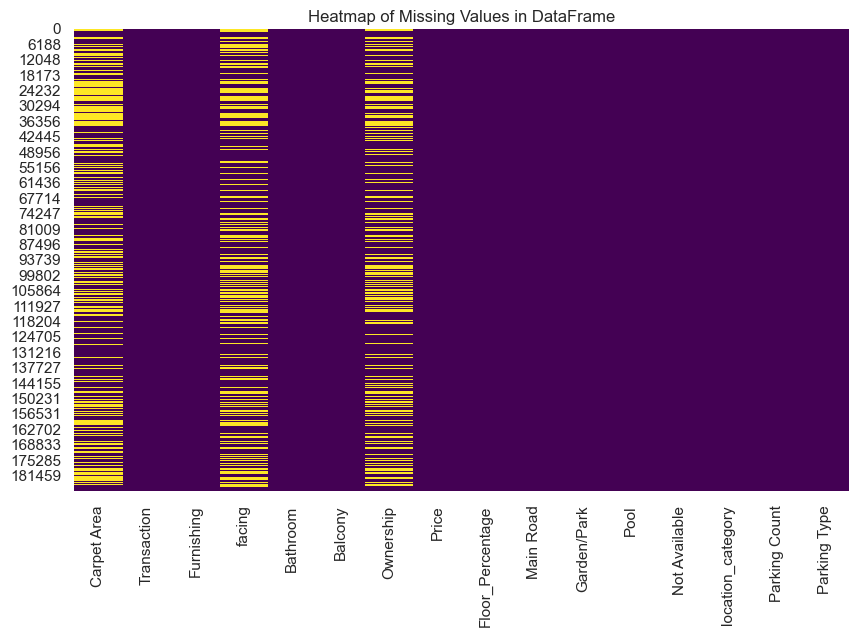

In [123]:
visualize_missing_data(data)

In [124]:
data.facing.fillna('Unknown', inplace=True)
data.Ownership.fillna('Unknown', inplace=True)

In [125]:
for column in data.columns:
    try:
        data[column] = pd.to_numeric(data[column])
    except:
        pass
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175785 entries, 0 to 187530
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Carpet Area        101510 non-null  float64
 1   Transaction        175785 non-null  object 
 2   Furnishing         175785 non-null  object 
 3   facing             175785 non-null  object 
 4   Bathroom           175785 non-null  int64  
 5   Balcony            175785 non-null  int64  
 6   Ownership          175785 non-null  object 
 7   Price              175785 non-null  float64
 8   Floor_Percentage   175785 non-null  float64
 9   Main Road          175785 non-null  int64  
 10  Garden/Park        175785 non-null  int64  
 11  Pool               175785 non-null  int64  
 12  Not Available      175785 non-null  int64  
 13  location_category  175785 non-null  object 
 14  Parking Count      175785 non-null  float64
 15  Parking Type       175785 non-null  object 
dtypes:


In this analysis, missing data in the 'Carpet Area' column is handled innovatively by encoding it into a binary 'Carpet_Available' field, rather than discarding it. This preserves valuable information and allows for exploring potential correlations with property prices. By calculating and visualizing the mean and median prices for properties with and without carpet area information, we gain insights into the impact of this data attribute on pricing trends. This approach enhances data integrity, supports more informed decision-making, and potentially improves the robustness of any predictive modeling undertaken.

In [126]:
data['Carpet_Available'] = data['Carpet Area'].notnull().astype(int)
data.drop(columns=['Carpet Area'], inplace=True)

# Calculate mean and median of 'Price' for each category of 'Carpet_Available'
mean_prices = data.groupby('Carpet_Available')['Price'].mean()
median_prices = data.groupby('Carpet_Available')['Price'].median()

# Creating subplots for mean and median
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plotting mean prices
sns.barplot(ax=axes[0], x=mean_prices.index, y=mean_prices.values)
axes[0].set_title('Mean Price by Carpet Availability')
axes[0].set_xlabel('Carpet Available (0 = No, 1 = Yes)')
axes[0].set_ylabel('Mean Price')

# Plotting median prices
sns.barplot(ax=axes[1], x=median_prices.index, y=median_prices.values)
axes[1].set_title('Median Price by Carpet Availability')
axes[1].set_xlabel('Carpet Available (0 = No, 1 = Yes)')
axes[1].set_ylabel('Median Price')

plt.tight_layout()
plt.show()

In [127]:
visualize_missing_data(data)

### **1.3 Exploratory Data Analysis**

In [128]:
data.sample(2).T

93844           168802
Transaction                Resale          Resale
Furnishing         Semi-Furnished  Semi-Furnished
facing                    Unknown            East
Bathroom                        3               3
Balcony                         2               2
Ownership                 Unknown        Freehold
Price                   6500000.0       9900000.0
Floor_Percentage             40.0            71.0
Main Road                       0               0
Garden/Park                     0               0
Pool                            0               0
Not Available                   0               0
location_category         Kolkata           Other
Parking Count                 0.0             1.0
Parking Type              Unknown         Covered
Carpet_Available                0               1

In [129]:
data.to_csv('data.csv', index=False)

In [130]:
def plot_categorical(data, categorical_variable, annot=False):

    # Create a figure with three subplots
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

    sns.countplot(data=data, x=categorical_variable, color='blue', ax=axs[0])
    axs[0].set_title(f'Distribution of {categorical_variable}')
    axs[0].set_xlabel(categorical_variable)
    axs[0].set_ylabel('Count')

    sns.barplot(data=data, x=categorical_variable, y='Price', palette='viridis', estimator=np.mean, ci=None, ax=axs[1])
    axs[1].set_title(f'Mean Price by {categorical_variable}')
    axs[1].set_xlabel(categorical_variable)
    axs[1].set_ylabel('Mean Price')

    if annot:
        means = data.groupby(categorical_variable)['Price'].mean().values
        for i, mean in enumerate(means):
            axs[1].text(i, mean, f'{mean:.2f}', ha='center', va='bottom', fontsize=12)

    sns.barplot(data=data, x=categorical_variable, y='Price', palette='viridis', estimator=np.median, ci=None, ax=axs[2])
    axs[2].set_title(f'Median Price by {categorical_variable}')
    axs[2].set_xlabel(categorical_variable)
    axs[2].set_ylabel('Median Price')

    if annot:
        medians = data.groupby(categorical_variable)['Price'].median().values
        for i, median in enumerate(medians):
            axs[2].text(i, median, f'{median:.2f}', ha='center', va='bottom', fontsize=12)

    for ax in axs:
        ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()


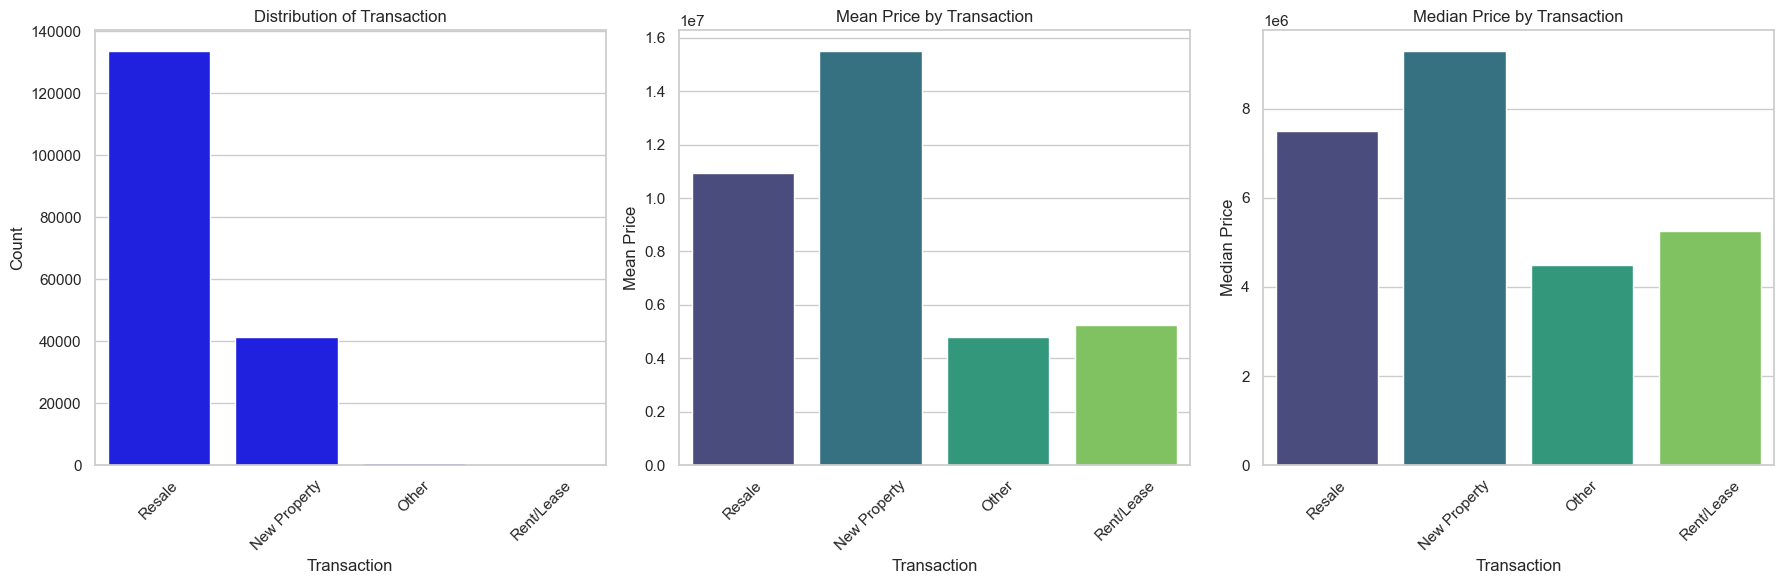

In [131]:
plot_categorical(data, 'Transaction')

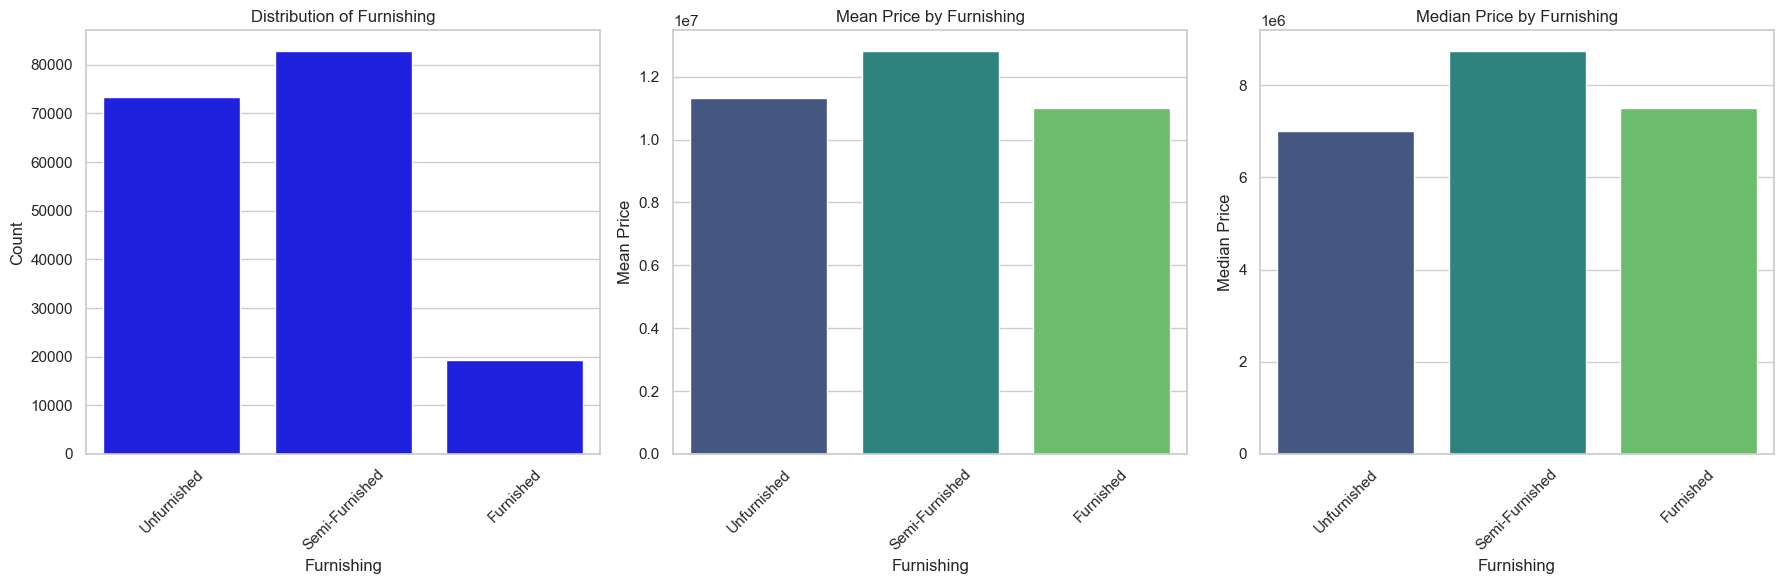

In [132]:
plot_categorical(data, categorical_variable = 'Furnishing')

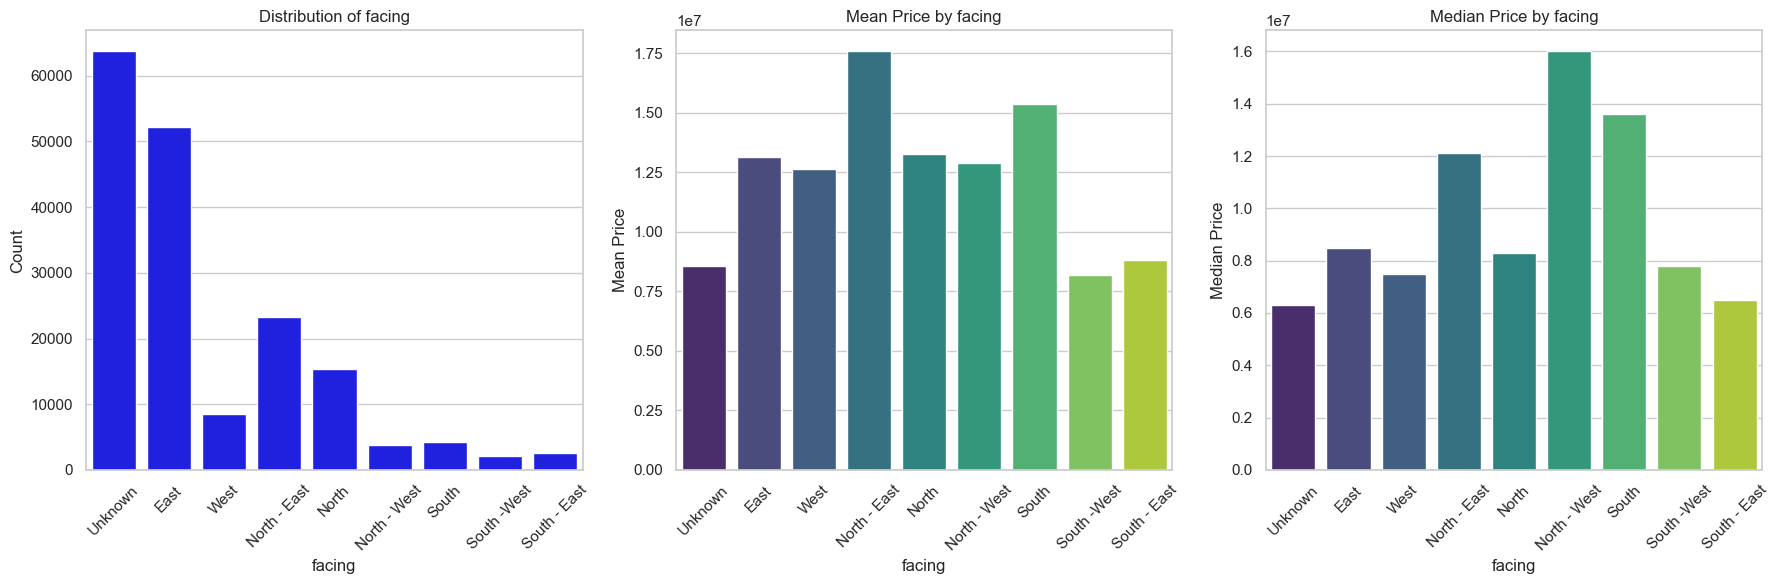

In [133]:
plot_categorical(data, categorical_variable = 'facing', annot=False)

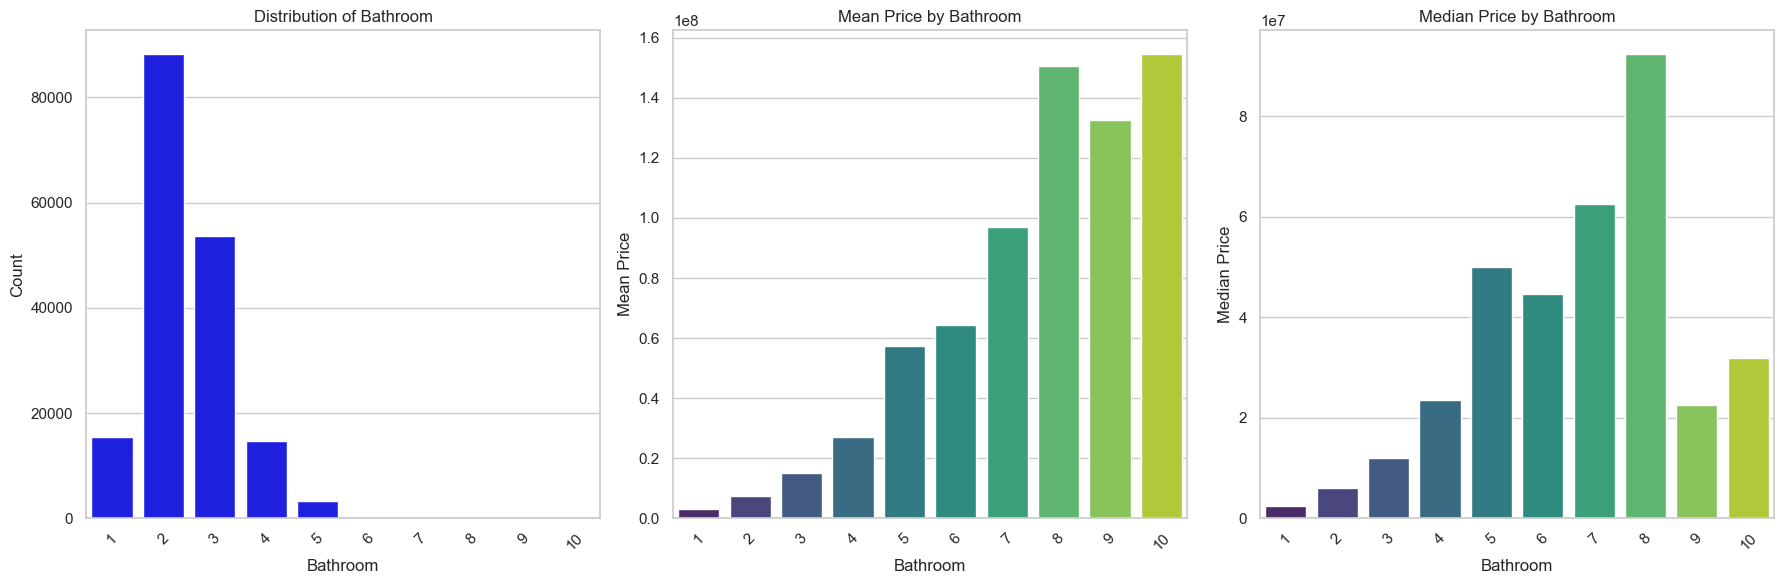

In [134]:
plot_categorical(data, categorical_variable = 'Bathroom', annot=False)

In [135]:
plot_categorical(data, categorical_variable = 'Balcony', annot=False)

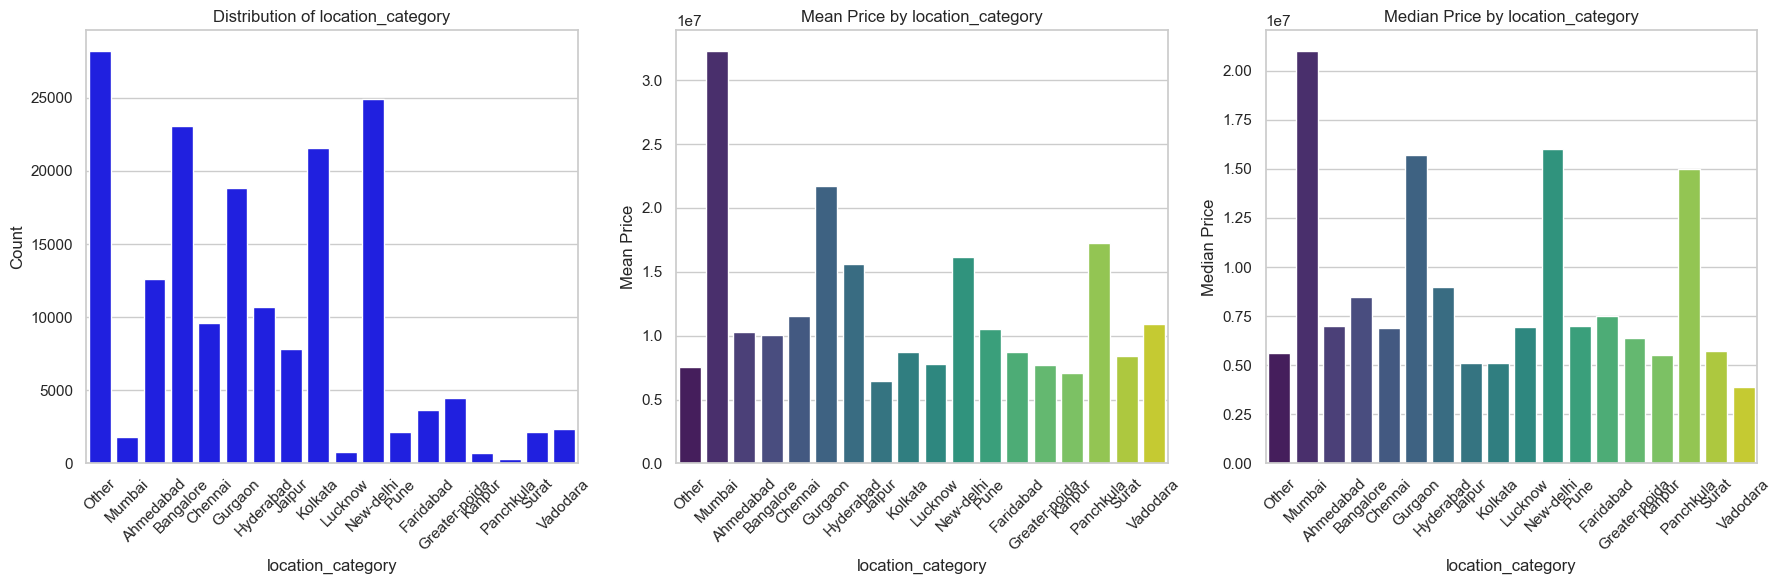

In [136]:
plot_categorical(data, categorical_variable = 'location_category', annot=False)

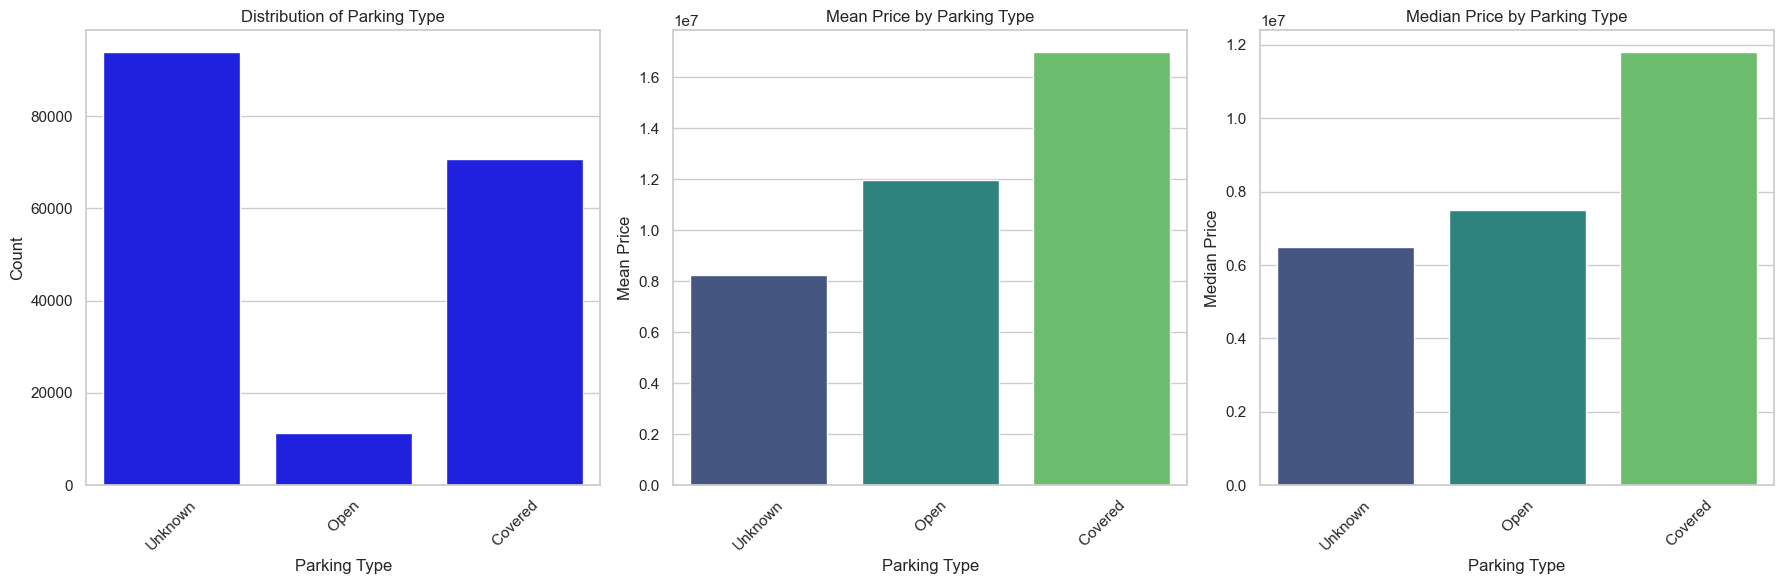

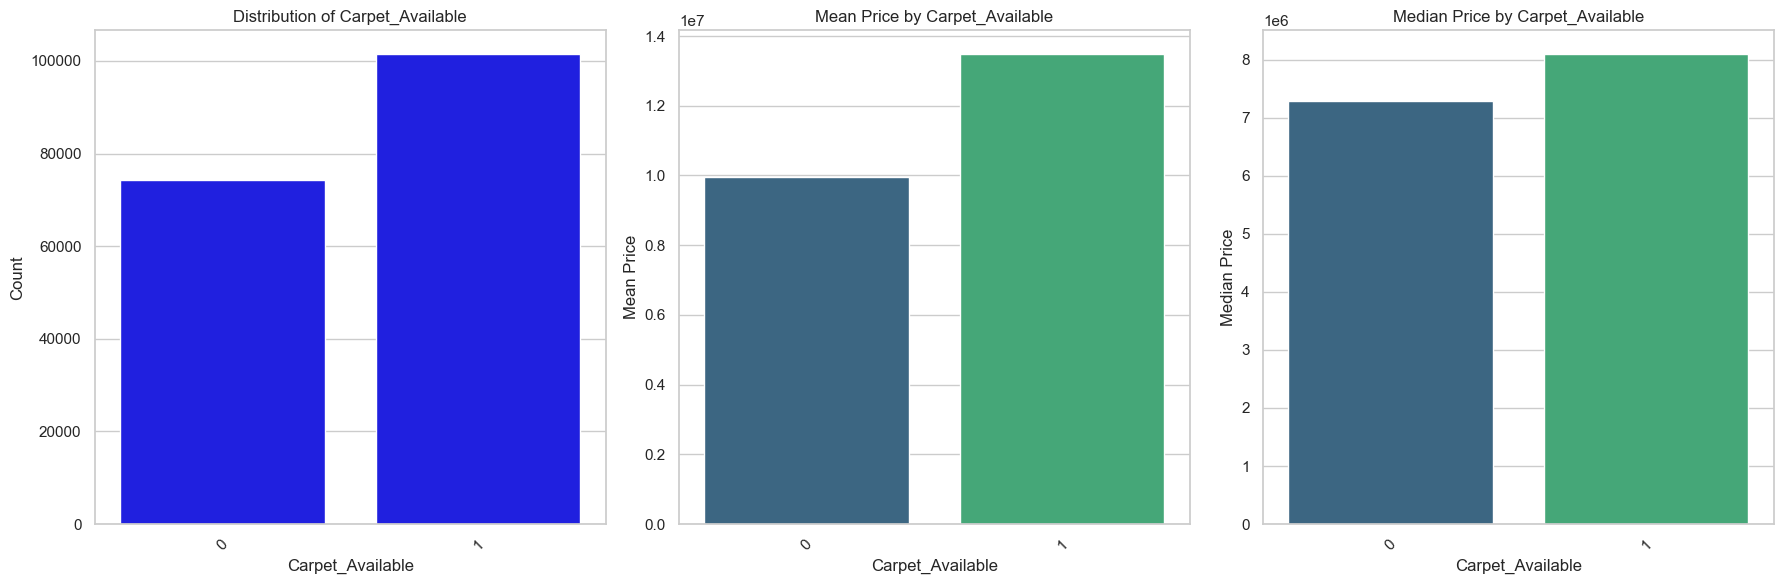

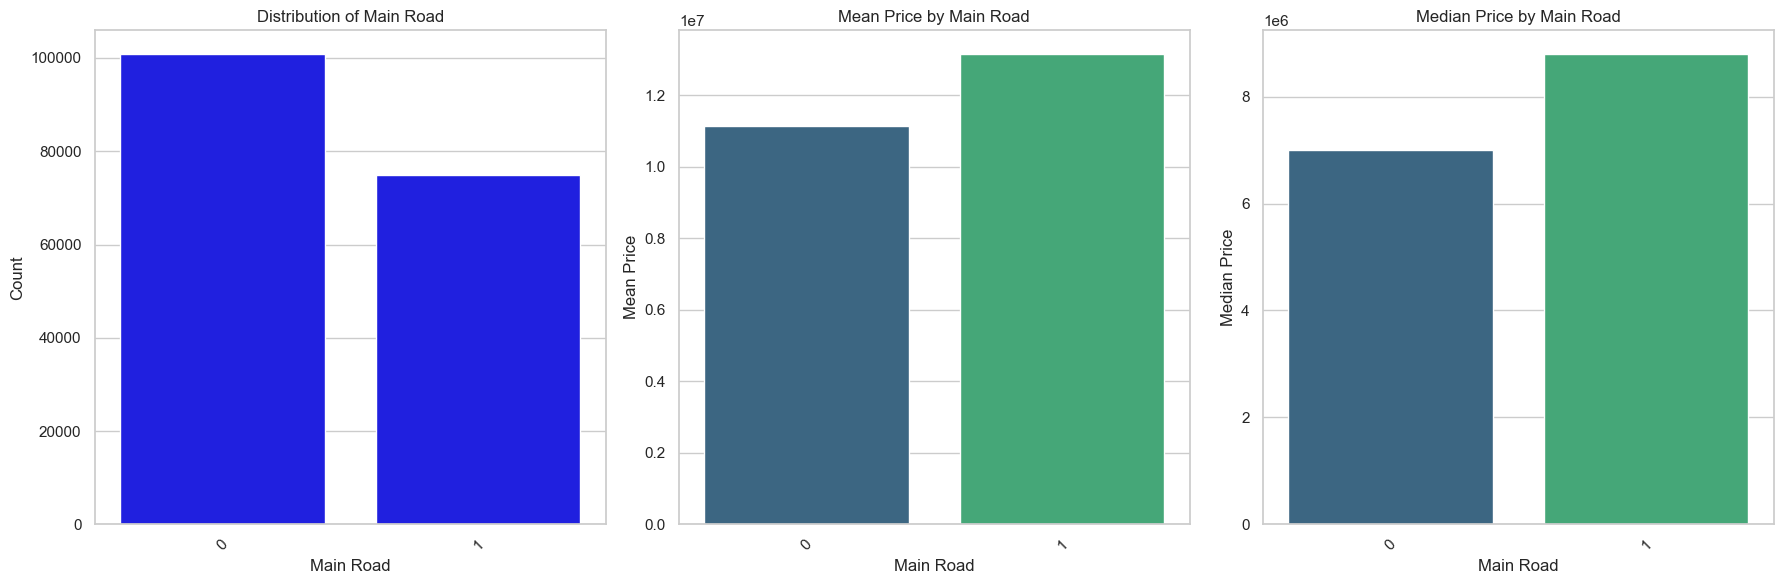

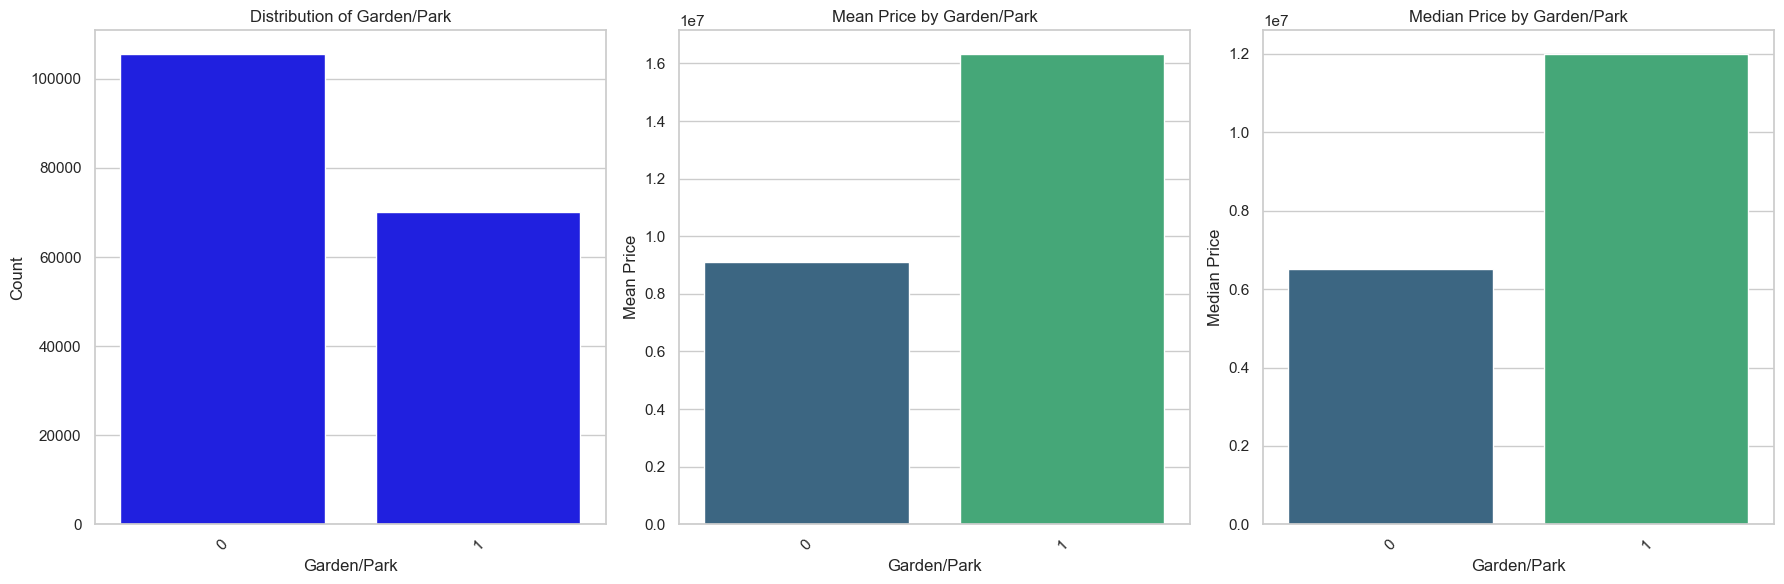

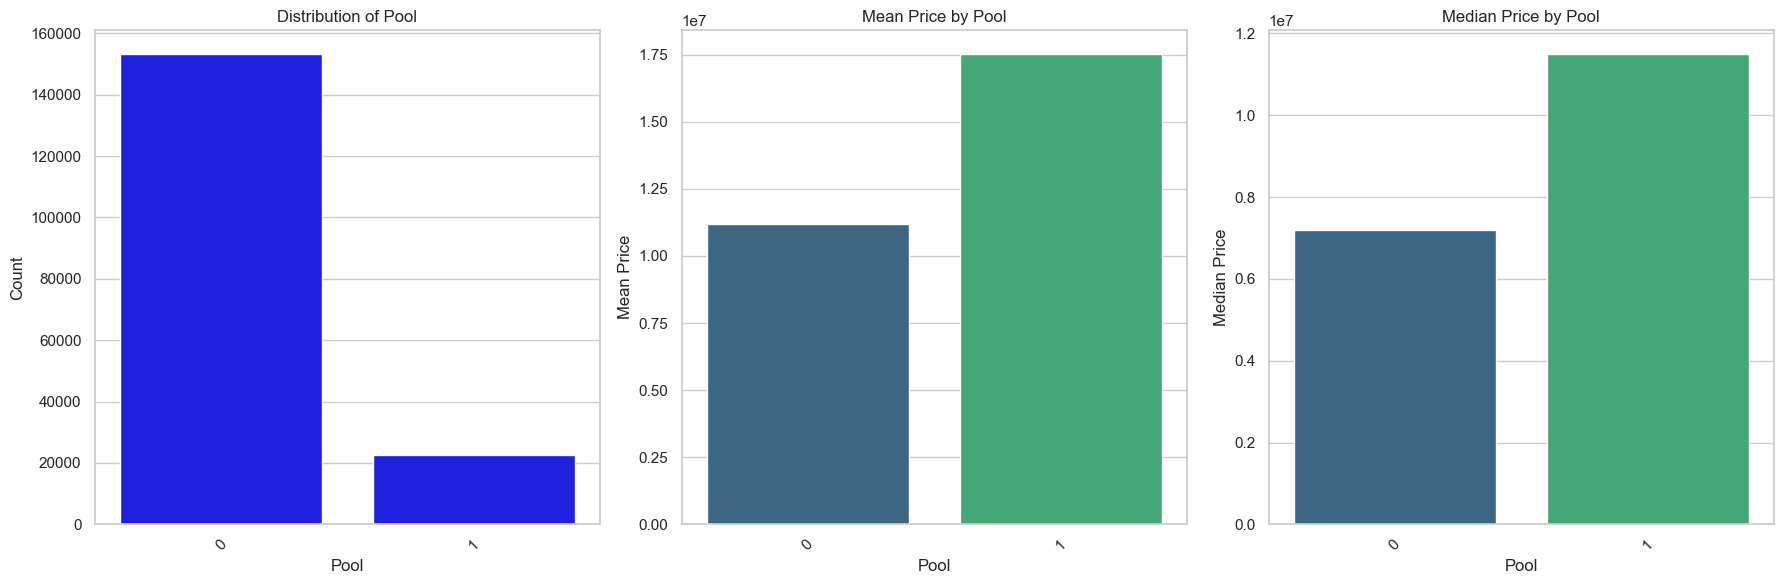

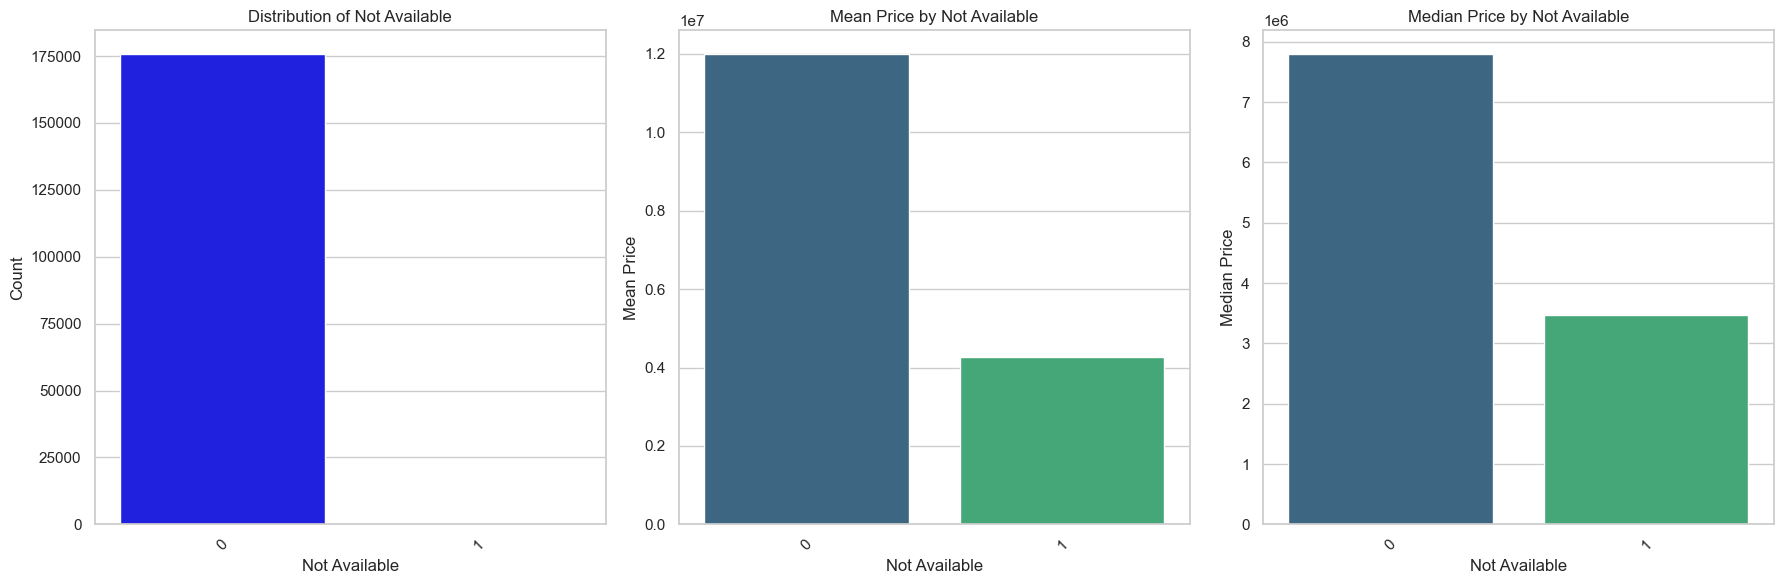

In [137]:
plot_categorical(data, categorical_variable ='Parking Type')
plot_categorical(data, categorical_variable ='Carpet_Available')
plot_categorical(data, categorical_variable ='Main Road')
plot_categorical(data, categorical_variable ='Garden/Park')
plot_categorical(data, categorical_variable ='Pool')
plot_categorical(data, categorical_variable ='Not Available')

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_continuous(data, continuous_variable, annot=True):

    # Create a figure with three subplots
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

    sns.histplot(data=data, x=continuous_variable, color='blue', ax=axs[0], bins=30, kde=True)
    axs[0].set_title(f'Distribution of {continuous_variable}')
    axs[0].set_xlabel(continuous_variable)
    axs[0].set_ylabel('Frequency')

    sns.scatterplot(data=data, x=continuous_variable, y='Price', color='green', ax=axs[1])
    axs[1].set_title(f'Scatter Plot of Price vs. {continuous_variable}')
    axs[1].set_xlabel(continuous_variable)
    axs[1].set_ylabel('Price')

    sns.regplot(data=data, x=continuous_variable, y='Price', color='red', ax=axs[2])
    axs[2].set_title(f'Regression Plot of Price vs. {continuous_variable}')
    axs[2].set_xlabel(continuous_variable)
    axs[2].set_ylabel('Price')

    if annot:
        corr = data[[continuous_variable, 'Price']].corr().iloc[0, 1]
        axs[2].text(0.1, 0.9, f'Correlation: {corr:.2f}', transform=axs[2].transAxes, fontsize=12)

    plt.tight_layout()
    plt.show()


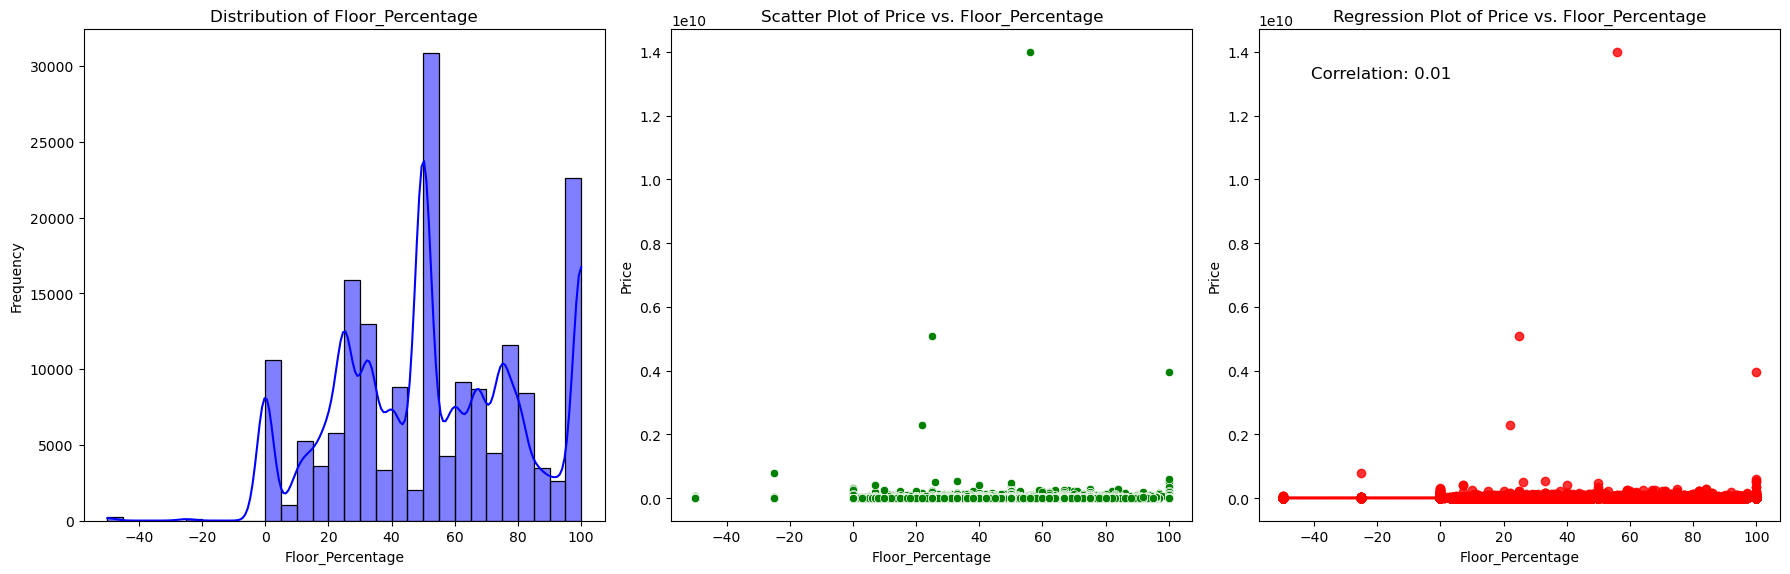

In [47]:
plot_continuous(data, 'Floor_Percentage')

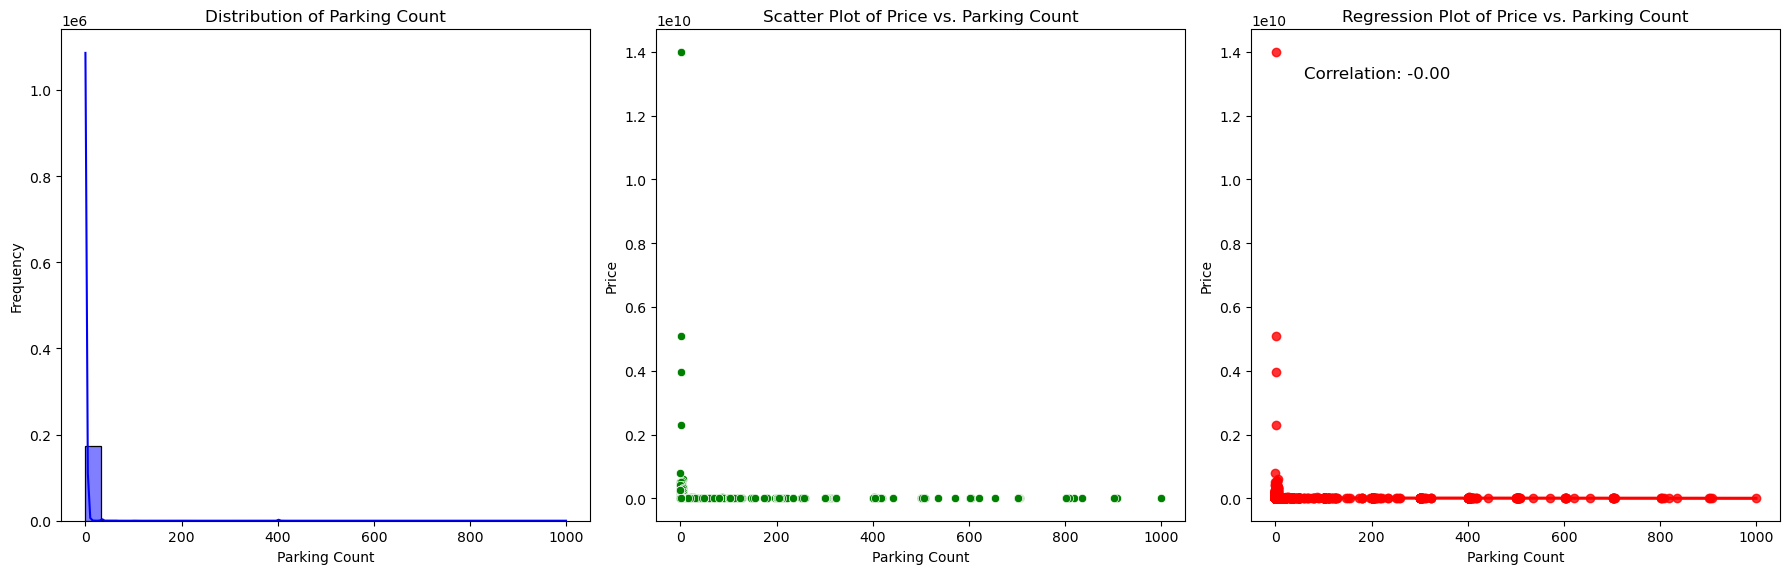

In [48]:
plot_continuous(data, 'Parking Count')

### **1.4 Data Transformation and Outlier Removal**


In [49]:
count_before = len(data)

# Calculate IQR
Q1 = data['Price'].quantile(0.25)
Q3 = data['Price'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Removing outliers
df_filtered = data[(data['Price'] >= lower_bound) & (data['Price'] <= upper_bound)]

# Record count after removing outliers
count_after = len(df_filtered)

# Output the counts
print(f"Record count before removing outliers: {count_before}")
print(f"Record count after removing outliers: {count_after}")


Record count before removing outliers: 175785
Record count after removing outliers: 165325


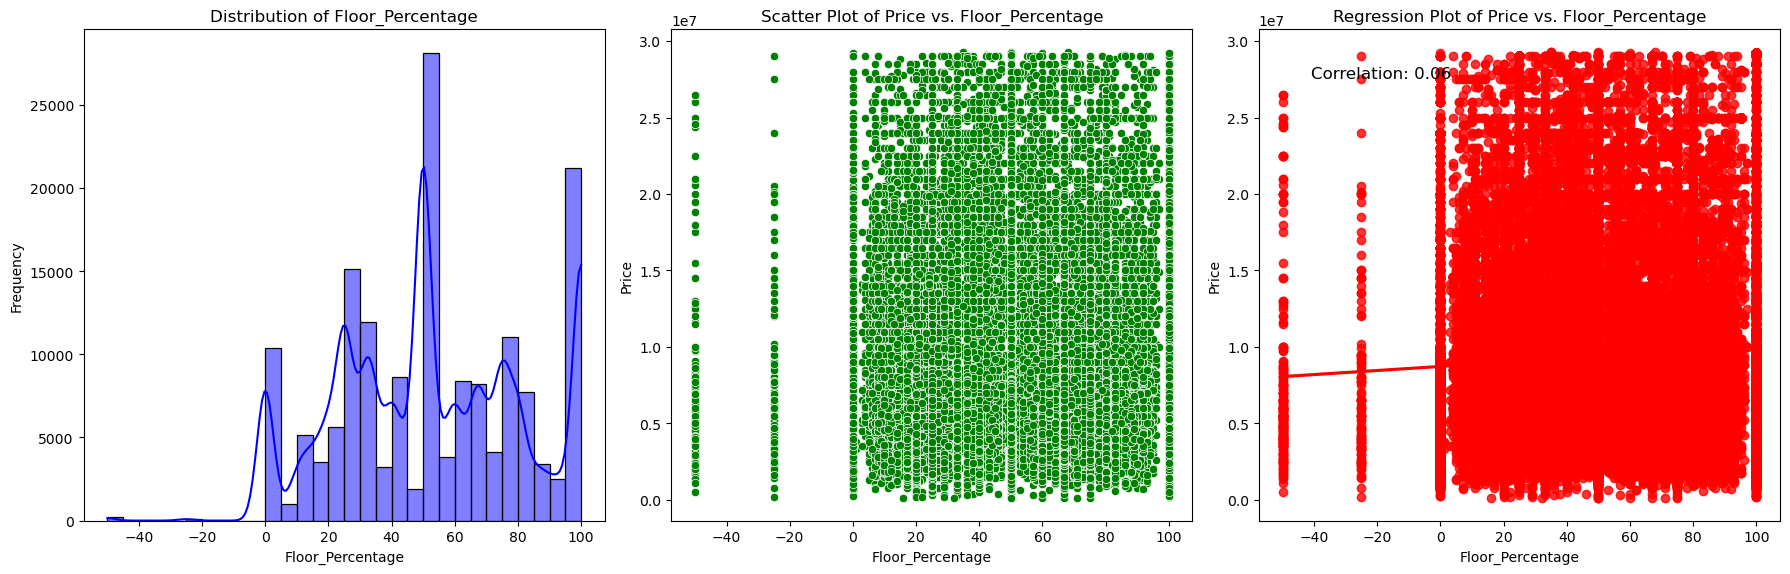

In [50]:
plot_continuous(df_filtered, 'Floor_Percentage')

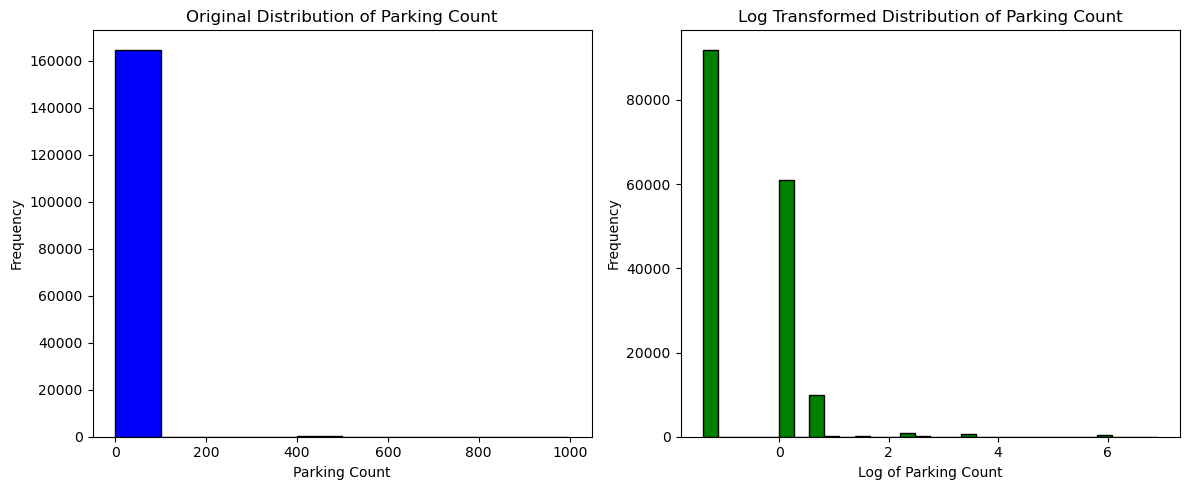

In [51]:
df_filtered['Parking Count Modified'] = df_filtered['Parking Count'].replace(0, 0.25)

# Plotting the original distribution of 'Parking Count'
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_filtered['Parking Count'], color='blue', edgecolor='black')
plt.title('Original Distribution of Parking Count')
plt.xlabel('Parking Count')
plt.ylabel('Frequency')

# Applying a logarithmic transformation
df_filtered['Parking Count Log'] = np.log(df_filtered['Parking Count Modified'])

# Plotting the transformed distribution
plt.subplot(1, 2, 2)
plt.hist(df_filtered['Parking Count Log'], bins=30, color='green', edgecolor='black')
plt.title('Log Transformed Distribution of Parking Count')
plt.xlabel('Log of Parking Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

df_filtered.drop(columns=['Parking Count', 'Parking Count Modified'], inplace=True)

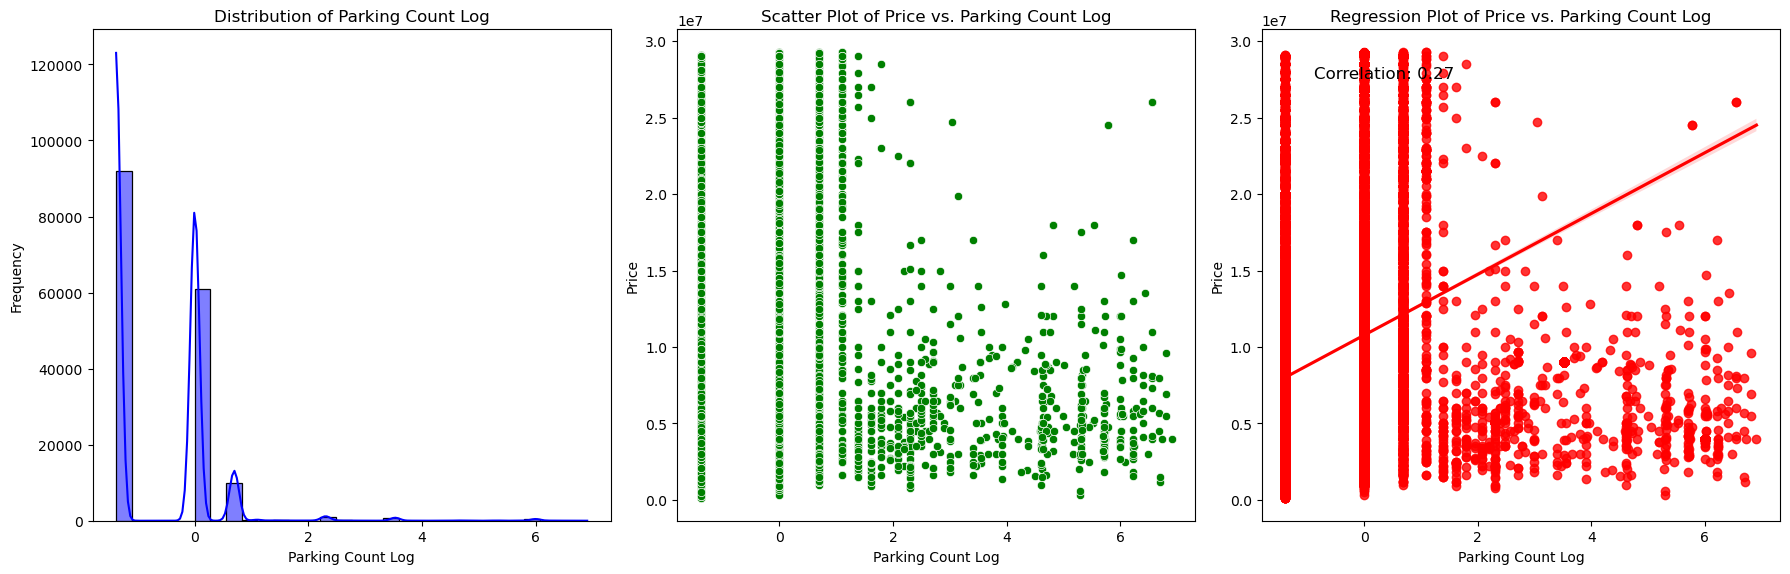

In [52]:
plot_continuous(df_filtered, 'Parking Count Log')

### **1.5 Categorical Encoding**

Categorical variables often need to be encoded into numerical form for machine learning algorithms.

##### Nominal Variables (One-Hot Encoding):

1. **Transaction:** Categorizes property transactions into "Resale," "New Property," "Other," and "Rent/Lease." No inherent order exists among these categories.
2. **facing:** Represents property orientations, such as "East," "North - East," etc. These categories have no natural hierarchy.
3. **Main Road:** Indicates whether a property is located on a main road (binary classification).
4. **Garden/Park:** Categorizes properties based on the presence or absence of a garden or park (binary).
5. **Pool:** Represents the presence or absence of a swimming pool (binary).
6. **Not Available:** Typically indicates missing or unavailable data (binary).
7. **location_category:** Categorizes properties by location (e.g., "New Delhi," "Kolkata"). No inherent order exists among locations.

##### Ordinal Variables (Ordinal Encoding):

1. **Furnishing:** Represents levels of property furnishing, including "Semi-Furnished," "Unfurnished," and "Furnished." These categories have a logical order.
2. **Bathroom:** Categorizes properties by the number of bathrooms, following a clear order (e.g., "1 Bathroom," "2 Bathrooms").
3. **Balcony:** Indicates the number of balconies in a property, with a clear ordering (e.g., "1 Balcony," "2 Balconies").
4. **Ownership:** Represents property ownership types, with "Freehold," "Leasehold," "Co-operative Society," and "Power Of Attorney." These categories reflect an order based on ownership rights.


In [53]:
encoded_data = df_filtered.copy()

In [54]:
# Ordinal Encoding
ownership_encoding = {
    "Unknown" : 0,
    "Freehold": 4,
    "Leasehold": 3,
    "Co-operative Society": 2,
    "Power Of Attorney": 1
}

furnishing_encoding = {
    "Semi-Furnished": 1,
    "Unfurnished": 2,
    "Furnished": 3
}

encoded_data.Ownership = encoded_data.Ownership.map(ownership_encoding)
encoded_data.Furnishing = encoded_data.Furnishing.map(furnishing_encoding)

In [55]:
# Nominal Encoding
encoded_data = pd.get_dummies(encoded_data, columns=['Transaction', 'facing', 'location_category', 'Parking Type'], prefix=['Transaction Type', 'Is Facing', 'Is Located in', 'Is Parking Type'], drop_first=True, dtype=int, prefix_sep=' ')

In [56]:
encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165325 entries, 0 to 187530
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Furnishing                   165325 non-null  int64  
 1   Bathroom                     165325 non-null  int64  
 2   Balcony                      165325 non-null  int64  
 3   Ownership                    165325 non-null  int64  
 4   Price                        165325 non-null  float64
 5   Floor_Percentage             165325 non-null  float64
 6   Main Road                    165325 non-null  int64  
 7   Garden/Park                  165325 non-null  int64  
 8   Pool                         165325 non-null  int64  
 9   Not Available                165325 non-null  int64  
 10  Carpet_Available             165325 non-null  int32  
 11  Parking Count Log            165325 non-null  float64
 12  Transaction Type Other       165325 non-null  int32  
 13 

### **1.6 Data Normalization**

Normalization ensures that features are on a consistent scale, preventing some features from dominating others. We will apply normalization techniques to our data.

### **1.7 Train, Test Split**

To evaluate the performance of machine learning models, we will split our data into training, testing, and validation sets.

In [57]:
# Separating the target variable and features
X = encoded_data.drop('Price', axis=1)
y = encoded_data['Price']

# Identifying numerical columns (excluding 'Price')
# numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Scaling only the numerical features
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# Splitting the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Output the shapes of the train and test sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (132260, 41) (132260,)
Testing set shape: (33065, 41) (33065,)


In [58]:
X_train.columns

Index(['Furnishing', 'Bathroom', 'Balcony', 'Ownership', 'Floor_Percentage',
       'Main Road', 'Garden/Park', 'Pool', 'Not Available', 'Carpet_Available',
       'Parking Count Log', 'Transaction Type Other',
       'Transaction Type Rent/Lease', 'Transaction Type Resale',
       'Is Facing North', 'Is Facing North - East', 'Is Facing North - West',
       'Is Facing South', 'Is Facing South - East', 'Is Facing South -West',
       'Is Facing Unknown', 'Is Facing West', 'Is Located in Bangalore',
       'Is Located in Chennai', 'Is Located in Faridabad',
       'Is Located in Greater-noida', 'Is Located in Gurgaon',
       'Is Located in Hyderabad', 'Is Located in Jaipur',
       'Is Located in Kanpur', 'Is Located in Kolkata',
       'Is Located in Lucknow', 'Is Located in Mumbai',
       'Is Located in New-delhi', 'Is Located in Other',
       'Is Located in Panchkula', 'Is Located in Pune', 'Is Located in Surat',
       'Is Located in Vadodara', 'Is Parking Type  Open',
       'Is

## 2. Model Training and Evaluation

- 2.1 Linear Regression
- 2.2 Linear Regression with Forward and Backward Selection
- 2.3 Linear Regression with RFE (Multi Colinearity)
- 2.4 Linear Regression with PCA
- 2.5 Lasso and Ridge Regression (Regularisation)
- 2.6 Decision Tree Model
- 2.7 Decision Tree Model With Cross validation and Hyper-Parameter Tuning
- 2.8 Random Forest
- 2.9 Random Forest Model With Cross validation and Hyper-Parameter Tuning
- 2.10 SVM

In [59]:
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set Seaborn style
sns.set(style="darkgrid")

def plot_regression_metrics(train_actual, train_predict, test_actual, test_predict, common_title):
    # Calculate various regression performance metrics
    train_mse = mean_squared_error(train_actual, train_predict)
    test_mse = mean_squared_error(test_actual, test_predict)
    train_mae = mean_absolute_error(train_actual, train_predict)
    test_mae = mean_absolute_error(test_actual, test_predict)
    train_r2 = r2_score(train_actual, train_predict)
    test_r2 = r2_score(test_actual, test_predict)

    # Define metric names and scores
    metrics = ['Mean Squared Error', 'Mean Absolute Error', 'R-squared']
    train_scores = [train_mse, train_mae, train_r2]
    test_scores = [test_mse, test_mae, test_r2]

    # Create subplots for each metric with a common title
    num_metrics = len(metrics)
    fig, axes = plt.subplots(1, num_metrics, figsize=(15, 5))
    fig.suptitle(common_title, fontsize=16)  # Set common title for all subplots

    for i in range(num_metrics):
        ax = axes[i]
        sns.barplot(x=['Train', 'Test'], y=[train_scores[i], test_scores[i]], ax=ax)
        ax.set_ylabel(metrics[i])
        ax.set_title(metrics[i], pad=10)

        # Add text labels at the top of the bars
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='baseline', fontsize=12, color='black')

    plt.tight_layout()
    plt.show()


**Linear Regression**

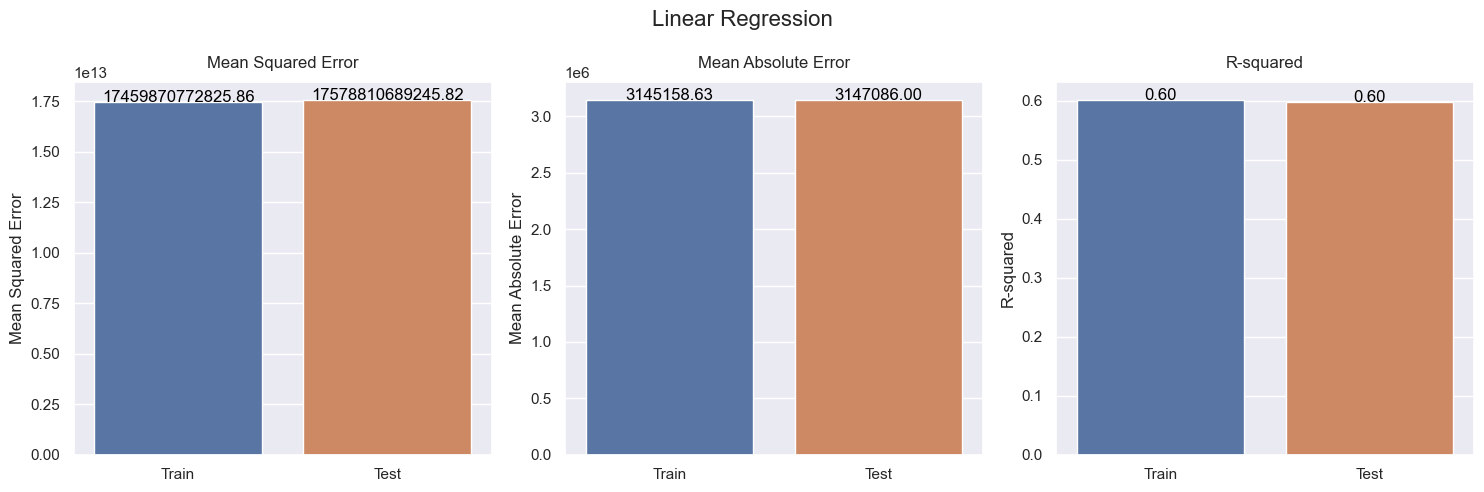

In [60]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

# Training the model on the training data
model.fit(X_train, y_train)


y_train_pred = model.predict(X_train)

# Predicting the target variable for the test data
y_test_pred = model.predict(X_test)

plot_regression_metrics(train_actual = y_train,
                        train_predict = y_train_pred,
                        test_actual = y_test,
                        test_predict = y_test_pred,
                        common_title='Linear Regression')


**Linear Regression With Forward Selection**

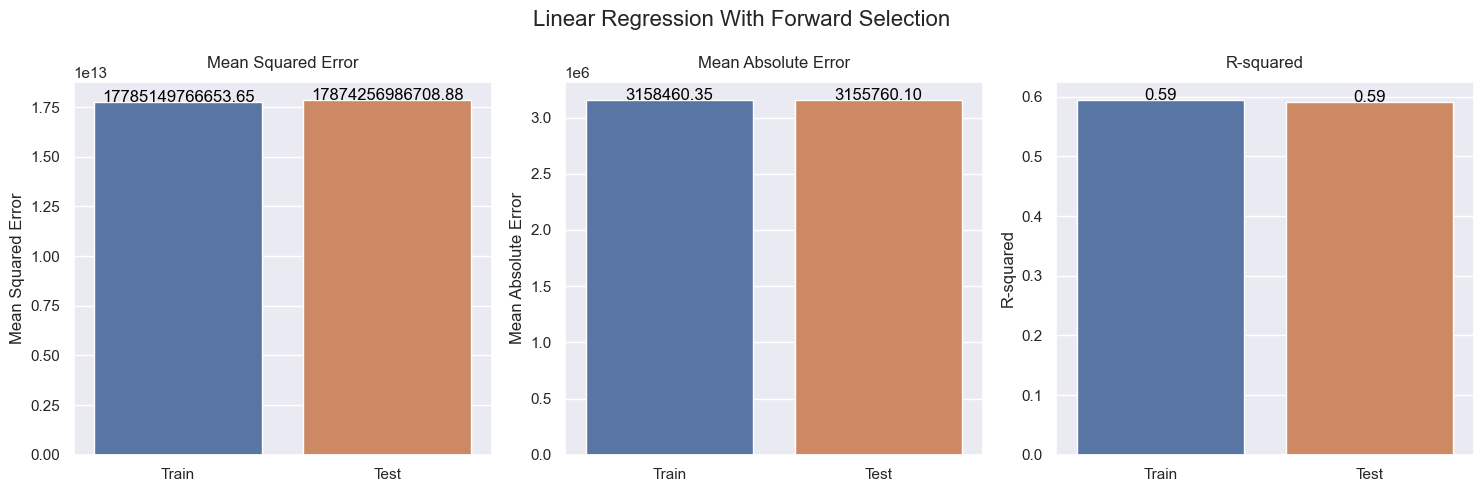

Selected Features: Index(['Bathroom', 'Balcony', 'Pool', 'Carpet_Available', 'Parking Count Log',
       'Is Facing North - East', 'Is Facing South', 'Is Facing South -West',
       'Is Located in Bangalore', 'Is Located in Faridabad',
       'Is Located in Greater-noida', 'Is Located in Gurgaon',
       'Is Located in Jaipur', 'Is Located in Kolkata', 'Is Located in Mumbai',
       'Is Located in New-delhi', 'Is Located in Other', 'Is Located in Surat',
       'Is Located in Vadodara', 'Is Parking Type Unknown'],
      dtype='object')


In [61]:
from sklearn.feature_selection import SequentialFeatureSelector

model = LinearRegression()
forward_selection = SequentialFeatureSelector(model, n_features_to_select="auto", direction='forward')

# Fitting the selector to the data
forward_selection.fit(X_train, y_train)

# Transforming the training and testing sets to include only the selected features
X_train_selected = forward_selection.transform(X_train)
X_test_selected = forward_selection.transform(X_test)

# Re-training the model on the selected features
model.fit(X_train_selected, y_train)

y_train_pred = model.predict(X_train_selected)

# Predicting the target variable for the test data
y_test_pred = model.predict(X_test_selected)

plot_regression_metrics(train_actual = y_train,
                        train_predict = y_train_pred,
                        test_actual = y_test,
                        test_predict = y_test_pred,
                        common_title='Linear Regression With Forward Selection')

selected_features = X_train.columns[forward_selection.get_support()]
print("Selected Features:", selected_features)


**Linear Regression With Backward Selection**

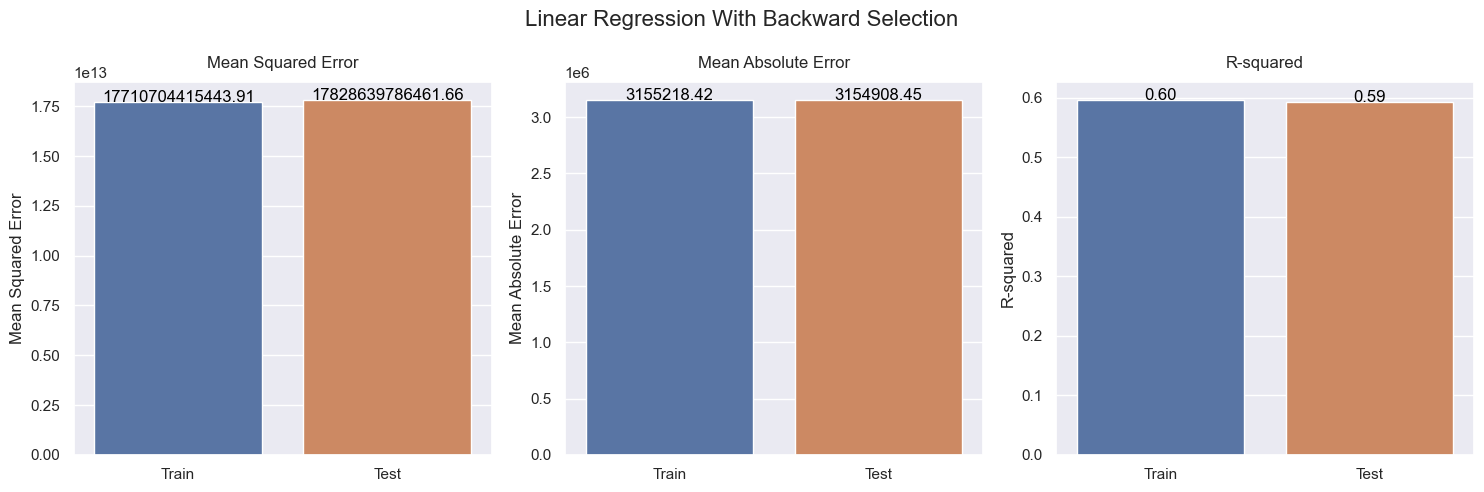

Selected Features: Index(['Bathroom', 'Balcony', 'Ownership', 'Pool', 'Carpet_Available',
       'Parking Count Log', 'Is Facing North - East', 'Is Facing South',
       'Is Facing South -West', 'Is Facing Unknown', 'Is Located in Bangalore',
       'Is Located in Greater-noida', 'Is Located in Gurgaon',
       'Is Located in Hyderabad', 'Is Located in Jaipur',
       'Is Located in Kolkata', 'Is Located in Mumbai',
       'Is Located in New-delhi', 'Is Located in Pune',
       'Is Located in Vadodara', 'Is Parking Type Unknown'],
      dtype='object')


In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector

model = LinearRegression()
forward_selection = SequentialFeatureSelector(model, n_features_to_select="auto", direction='backward')

# Fitting the selector to the data
forward_selection.fit(X_train, y_train)

# Transforming the training and testing sets to include only the selected features
X_train_selected = forward_selection.transform(X_train)
X_test_selected = forward_selection.transform(X_test)

# Re-training the model on the selected features
model.fit(X_train_selected, y_train)

y_train_pred = model.predict(X_train_selected)

# Predicting the target variable for the test data
y_test_pred = model.predict(X_test_selected)

plot_regression_metrics(train_actual = y_train,
                        train_predict = y_train_pred,
                        test_actual = y_test,
                        test_predict = y_test_pred,
                        common_title='Linear Regression With Backward Selection')

selected_features = X_train.columns[forward_selection.get_support()]
print("Selected Features:", selected_features)


**Linear Regression With VIF**

In [65]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Sort the DataFrame by VIF in descending order
vif_sorted = vif.sort_values(by='VIF', ascending=False)

# Filter rows where VIF is greater than 5
vif_filtered = vif_sorted[vif_sorted['VIF'] > 5]
vif_filtered


Variable        VIF
1                  Bathroom  12.555511
40  Is Parking Type Unknown  10.950419
2                   Balcony  10.388889
3                 Ownership   8.194856
10        Parking Count Log   6.946695
0                Furnishing   6.834088
20        Is Facing Unknown   5.165527
13  Transaction Type Resale   5.126988

In [66]:
# Dropping "Bathroom"
X_filtered = X.drop(columns=['Bathroom'])
vif = pd.DataFrame()
vif["Variable"] = X_filtered.columns
vif["VIF"] = [variance_inflation_factor(X_filtered.values, i) for i in range(X_filtered.shape[1])]

# Sort the DataFrame by VIF in descending order
vif_sorted = vif.sort_values(by='VIF', ascending=False)

# Filter rows where VIF is greater than 5
vif_filtered = vif_sorted[vif_sorted['VIF'] > 5]
vif_filtered

Variable        VIF
39  Is Parking Type Unknown  10.935788
1                   Balcony   8.912614
2                 Ownership   7.793647
9         Parking Count Log   6.942335
0                Furnishing   6.590406
12  Transaction Type Resale   5.122451

In [67]:
# Dropping "Bathroom"
X_filtered = X.drop(columns=['Bathroom', 'Is Parking Type Unknown'])
vif = pd.DataFrame()
vif["Variable"] = X_filtered.columns
vif["VIF"] = [variance_inflation_factor(X_filtered.values, i) for i in range(X_filtered.shape[1])]

# Sort the DataFrame by VIF in descending order
vif_sorted = vif.sort_values(by='VIF', ascending=False)

# Filter rows where VIF is greater than 5
vif_filtered = vif_sorted[vif_sorted['VIF'] > 5]
vif_filtered

Variable       VIF
1     Balcony  8.909004
2   Ownership  7.763347
0  Furnishing  6.476505

In [68]:
# Dropping "Bathroom", 'Is Parking Type Unknown', 'Balcony'
X_filtered = X.drop(columns=['Bathroom', 'Is Parking Type Unknown', 'Balcony'])
vif = pd.DataFrame()
vif["Variable"] = X_filtered.columns
vif["VIF"] = [variance_inflation_factor(X_filtered.values, i) for i in range(X_filtered.shape[1])]

# Sort the DataFrame by VIF in descending order
vif_sorted = vif.sort_values(by='VIF', ascending=False)

# Filter rows where VIF is greater than 5
vif_filtered = vif_sorted[vif_sorted['VIF'] > 5]
vif_filtered

Variable       VIF
1   Ownership  7.731278
0  Furnishing  6.465380

In [69]:
# Dropping "Bathroom", 'Is Parking Type Unknown', 'Balcony', 'Ownership', 'Furnishing
X_filtered = X.drop(columns=['Bathroom', 'Is Parking Type Unknown', 'Balcony', 'Ownership', 'Furnishing'])
vif = pd.DataFrame()
vif["Variable"] = X_filtered.columns
vif["VIF"] = [variance_inflation_factor(X_filtered.values, i) for i in range(X_filtered.shape[1])]

# Sort the DataFrame by VIF in descending order
vif_sorted = vif.sort_values(by='VIF', ascending=False)

# Filter rows where VIF is greater than 5
vif_filtered = vif_sorted[vif_sorted['VIF'] > 5]
vif_filtered

Empty DataFrame
Columns: [Variable, VIF]
Index: []

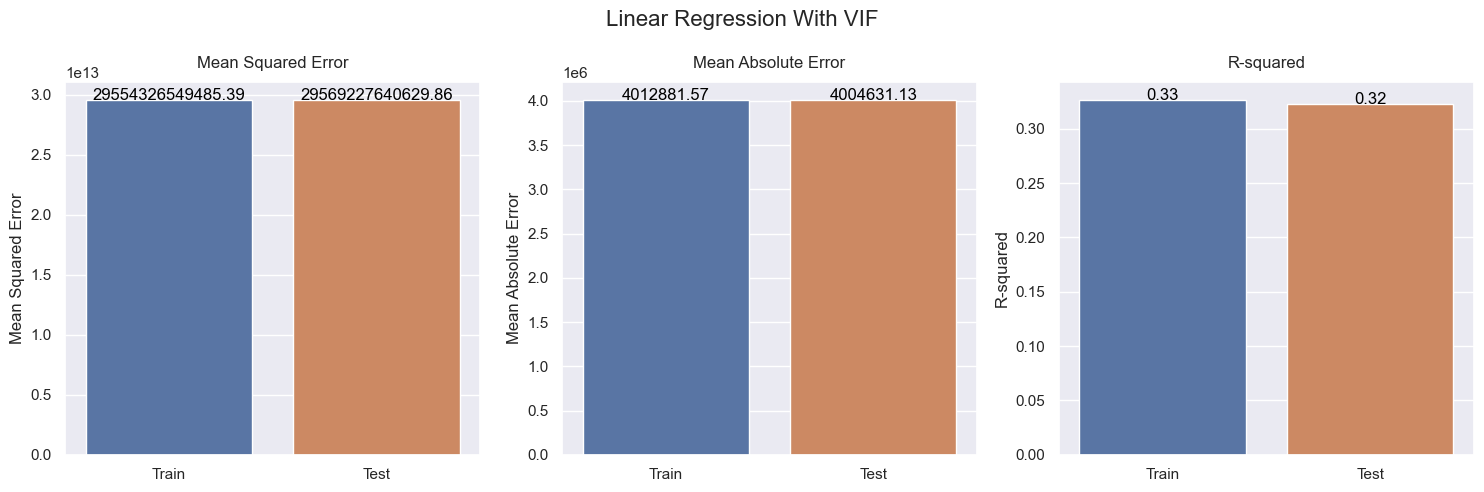

Selected Features: Index(['Bathroom', 'Balcony', 'Ownership', 'Pool', 'Carpet_Available',
       'Parking Count Log', 'Is Facing North - East', 'Is Facing South',
       'Is Facing South -West', 'Is Facing Unknown', 'Is Located in Bangalore',
       'Is Located in Greater-noida', 'Is Located in Gurgaon',
       'Is Located in Hyderabad', 'Is Located in Jaipur',
       'Is Located in Kolkata', 'Is Located in Mumbai',
       'Is Located in New-delhi', 'Is Located in Pune',
       'Is Located in Vadodara', 'Is Parking Type Unknown'],
      dtype='object')


In [70]:
features_to_exclude = ['Bathroom', 'Is Parking Type Unknown', 'Balcony', 'Ownership', 'Furnishing']

# Create a new DataFrame without the excluded features
X_train_filtered = X_train.drop(columns=features_to_exclude)
X_test_filtered = X_test.drop(columns=features_to_exclude)

# Initialize and train a linear regression model (you can use another regression model if preferred)
regression_model = LinearRegression()
regression_model.fit(X_train_filtered, y_train)

y_train_pred = regression_model.predict(X_train_filtered)

# Predicting the target variable for the test data
y_test_pred = regression_model.predict(X_test_filtered)

plot_regression_metrics(train_actual = y_train,
                        train_predict = y_train_pred,
                        test_actual = y_test,
                        test_predict = y_test_pred,
                        common_title='Linear Regression With VIF')

selected_features = X_train.columns[forward_selection.get_support()]
print("Selected Features:", selected_features)


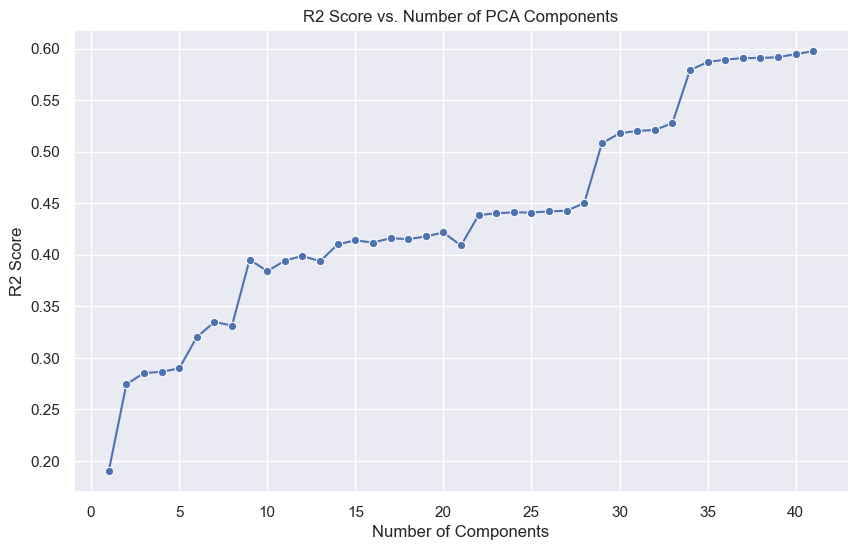

In [71]:
from sklearn.decomposition import PCA

# Initialize lists to store R2 scores and the number of components
r2_scores = []
num_components_list = range(1, X_train.shape[1] + 1)  # Loop through all available columns

for num_components in num_components_list:
    # Apply PCA with the current number of components
    pca = PCA(n_components=num_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Initialize and train a Linear Regression model on the reduced feature space
    regression_model = LinearRegression()
    regression_model.fit(X_train_pca, y_train)

    # Predict on the test set
    y_test_pred = regression_model.predict(X_test_pca)

    # Calculate R-squared (R2) score
    r2 = r2_score(y_test, y_test_pred)
    r2_scores.append(r2)

# Create a Seaborn lineplot of R2 scores vs. Number of Components
plt.figure(figsize=(10, 6))
sns.lineplot(x=num_components_list, y=r2_scores, marker='o')
plt.title('R2 Score vs. Number of PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('R2 Score')
plt.grid(True)
plt.show()

**Lasso Regression**

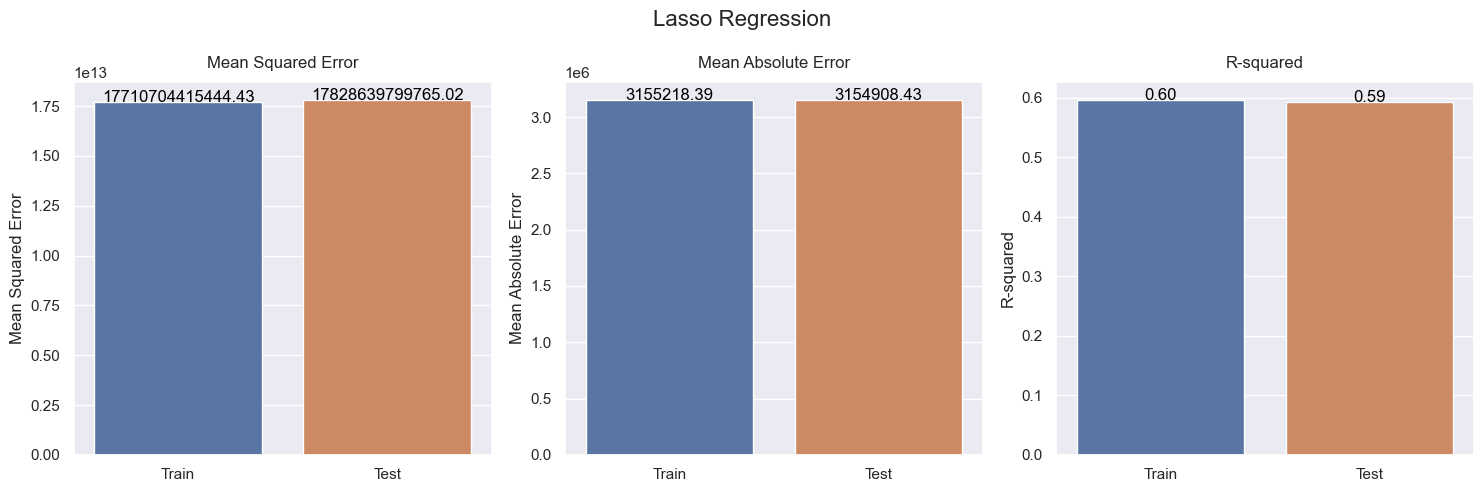

In [72]:
from sklearn.linear_model import Lasso

# Initializing the Lasso Regression model with an alpha value
lasso_model = Lasso(alpha=0.1) 

# Training the model
lasso_model.fit(X_train[selected_features], y_train)

y_train_pred = lasso_model.predict(X_train[selected_features])

# Predicting the target variable for the test data
y_test_pred = lasso_model.predict(X_test[selected_features])

plot_regression_metrics(train_actual = y_train,
                        train_predict = y_train_pred,
                        test_actual = y_test,
                        test_predict = y_test_pred,
                        common_title='Lasso Regression')

**Ridge Regression**

In [73]:
from sklearn.linear_model import Ridge

# Initializing the Ridge Regression model with an alpha value
ridge_model = Ridge(alpha=2)  # Adjust the alpha value as needed

# Training the model
ridge_model.fit(X_train[selected_features], y_train)

y_train_pred = ridge_model.predict(X_train[selected_features])

# Predicting the target variable for the test data
y_test_pred = ridge_model.predict(X_test[selected_features])

plot_regression_metrics(train_actual = y_train,
                        train_predict = y_train_pred,
                        test_actual = y_test,
                        test_predict = y_test_pred,
                        common_title='Ridge Regression')


**Decision Trees**

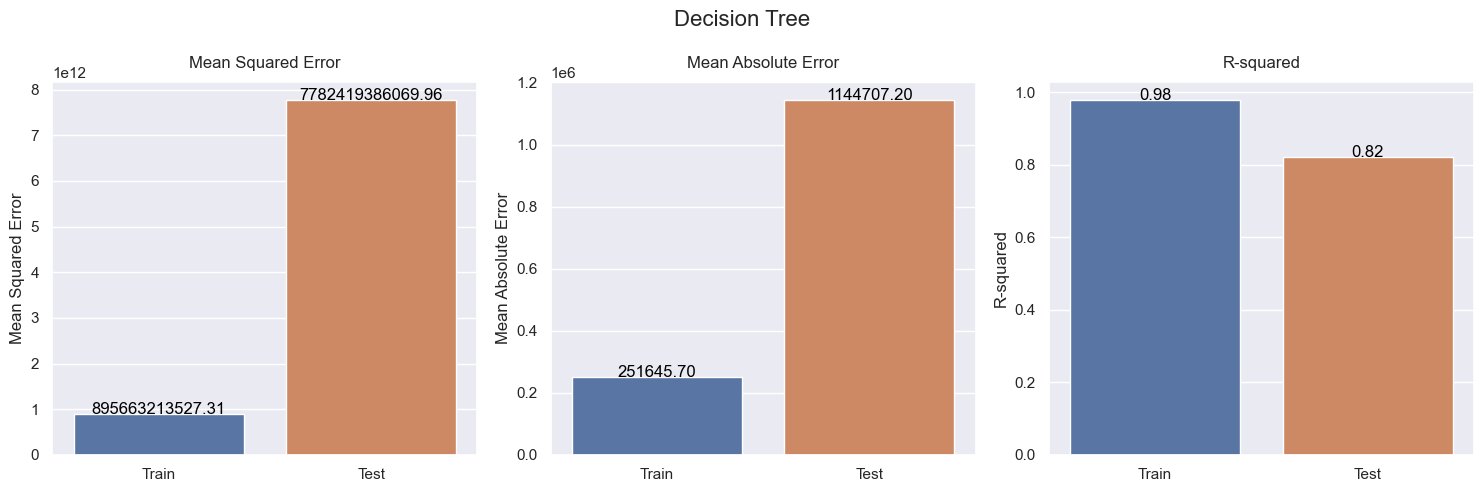

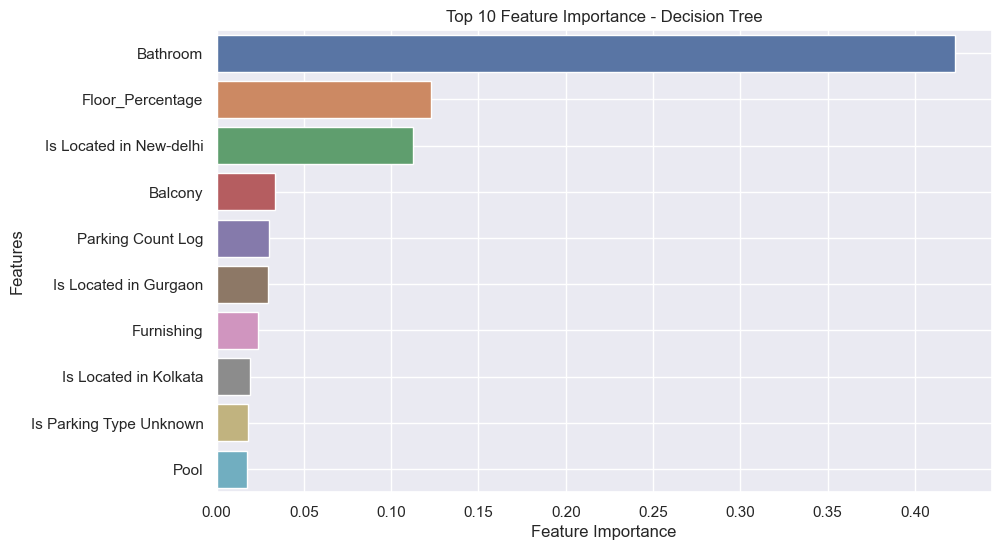

In [74]:
from sklearn.tree import DecisionTreeRegressor

# Initializing the Decision Tree Regression model
decision_tree_model = DecisionTreeRegressor(random_state=42)

# Training the model on the training data
decision_tree_model.fit(X_train, y_train)

y_train_pred = decision_tree_model.predict(X_train)

# Predicting the target variable for the test data
y_test_pred = decision_tree_model.predict(X_test)

plot_regression_metrics(train_actual = y_train,
                        train_predict = y_train_pred,
                        test_actual = y_test,
                        test_predict = y_test_pred,
                        common_title='Decision Tree')

# Calculate feature importances
feature_importances = decision_tree_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
top_10_features = importance_df.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_features)
plt.title('Top 10 Feature Importance - Decision Tree')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.grid(True)
plt.show()


**Random Forest**

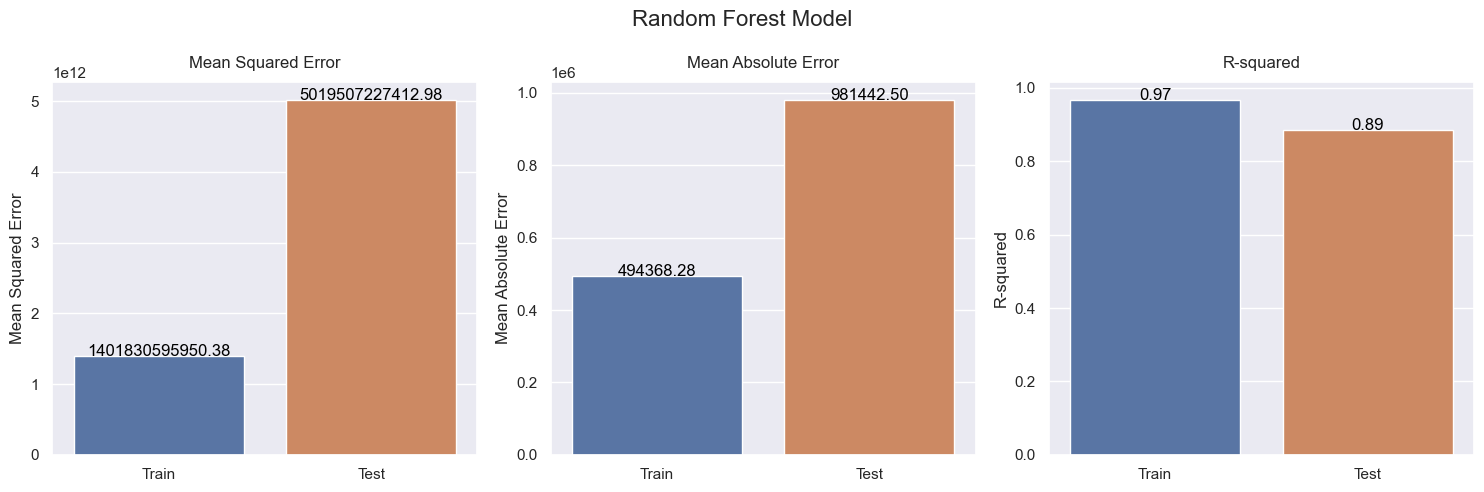

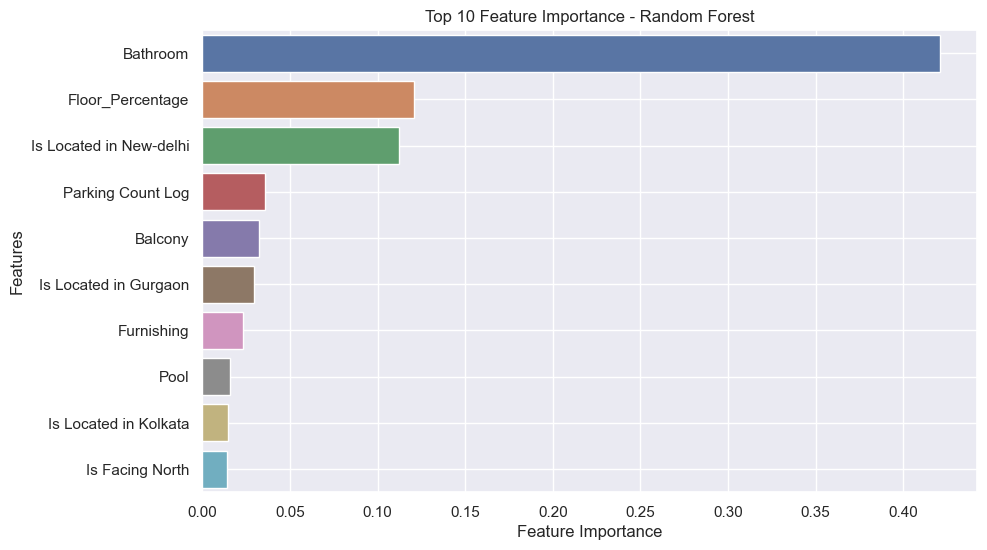

In [75]:
from sklearn.ensemble import RandomForestRegressor

# Initializing the Decision Tree Regression model
random_forest_model = RandomForestRegressor(random_state=42)

# Training the model on the training data
random_forest_model.fit(X_train, y_train)

y_train_pred = random_forest_model.predict(X_train)

# Predicting the target variable for the test data
y_test_pred = random_forest_model.predict(X_test)

plot_regression_metrics(train_actual = y_train,
                        train_predict = y_train_pred,
                        test_actual = y_test,
                        test_predict = y_test_pred,
                        common_title='Random Forest Model')

feature_importances = random_forest_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
top_10_features = importance_df.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_features)
plt.title('Top 10 Feature Importance - Random Forest')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.grid(True)
plt.show()

**Decision Tree : Hyper-Parameter Tuning and Cross Validation**

Fitting 5 folds for each of 48 candidates, totalling 240 fits


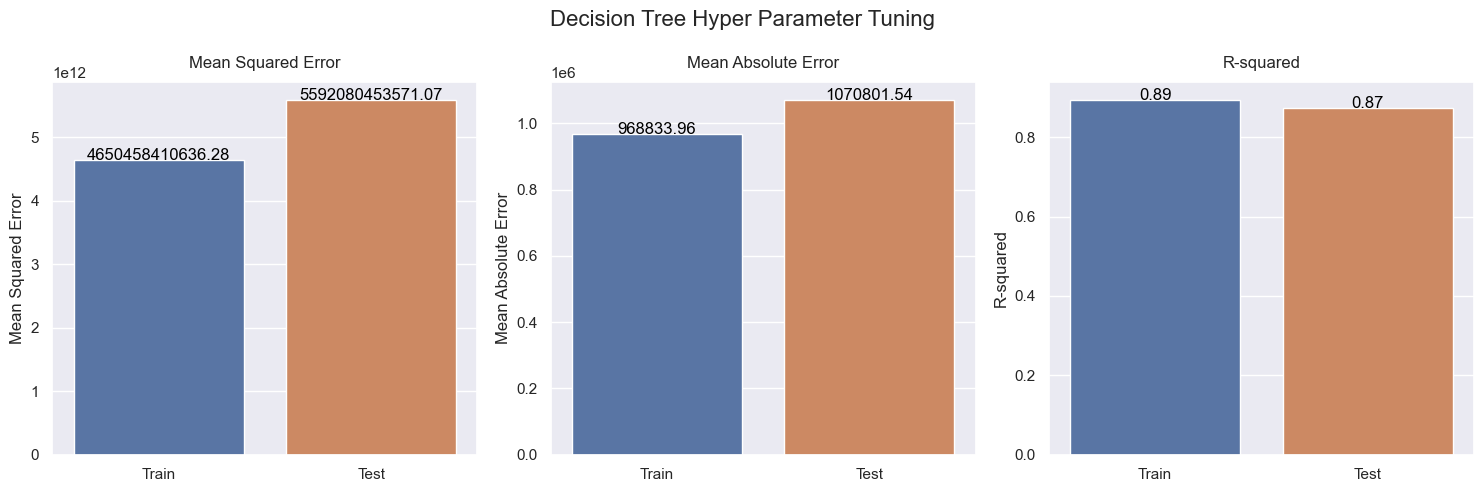

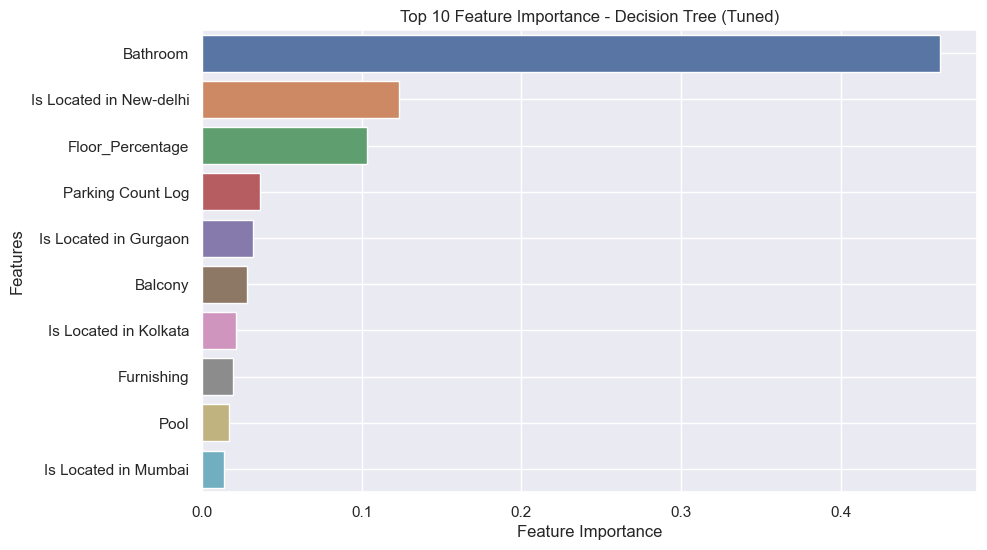

In [76]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Parameter grid for Decision Tree
param_grid = {
    'max_depth': [None, 25, 30, 35],
    'min_samples_split': [55, 60, 65],
    'min_samples_leaf': [5,6,7,8]
}

# Initializing the Decision Tree Regressor
dtree_model = DecisionTreeRegressor(random_state=42)

# Setting up Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=dtree_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fitting Grid Search
grid_search.fit(X_train, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluating the best model on the test data
best_model = grid_search.best_estimator_
y_train_pred = best_model.predict(X_train)

# Predicting the target variable for the test data
y_test_pred = best_model.predict(X_test)

plot_regression_metrics(train_actual = y_train,
                        train_predict = y_train_pred,
                        test_actual = y_test,
                        test_predict = y_test_pred,
                        common_title='Decision Tree Hyper Parameter Tuning')

feature_importances = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
top_10_features = importance_df.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_features)
plt.title('Top 10 Feature Importance - Decision Tree (Tuned)')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.grid(True)
plt.show()


In [77]:
best_model

DecisionTreeRegressor(max_depth=30, min_samples_leaf=8, min_samples_split=60,
                      random_state=42)

**RandomForest : Cross Validation and HyperParameter Tuning**

In [78]:
# Parameter grid for Decision Tree
param_grid = {
    'n_estimators': [30, 100],
    'max_depth': [50, 100, 150],
    'min_samples_split': [40, 55],
    'min_samples_leaf': [3, 4, 5]
}

# Initializing the Decision Tree Regressor
rf_model = RandomForestRegressor(random_state=42)

# Setting up Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=3, scoring='neg_mean_squared_error')

# Fitting Grid Search
grid_search.fit(X_train, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluating the best model on the test data
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 36 candidates, totalling 180 fits


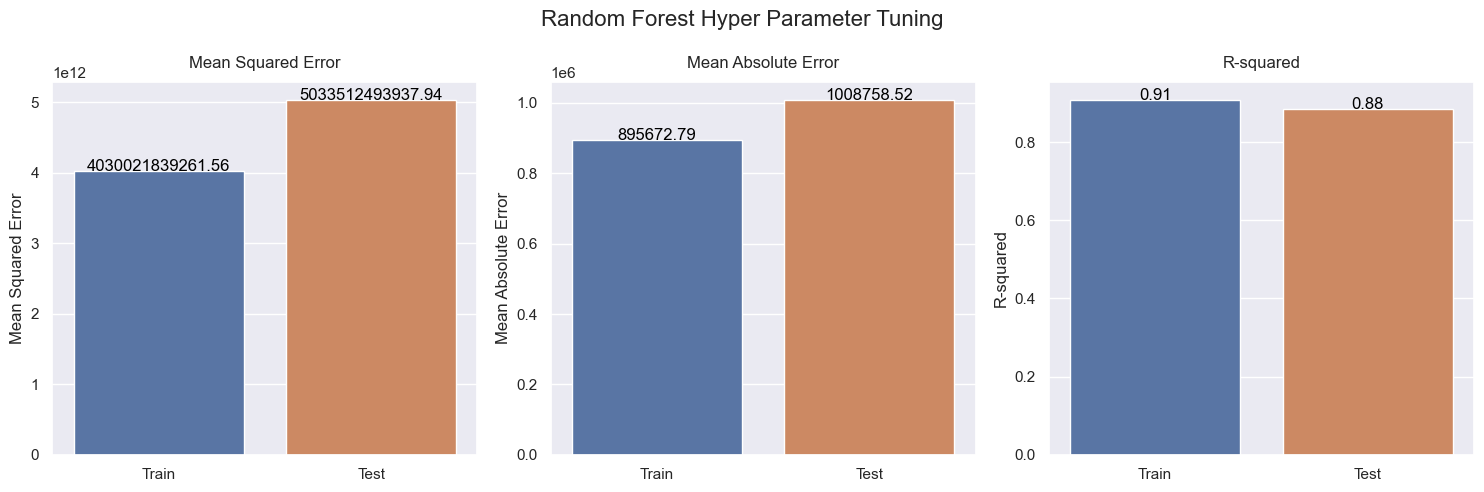

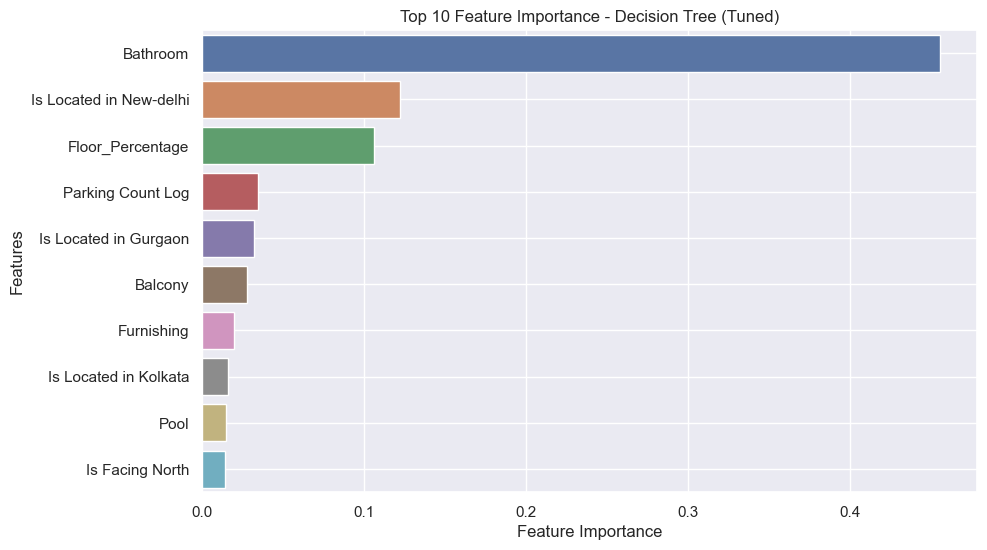

RandomForestRegressor(max_depth=50, min_samples_leaf=3, min_samples_split=40,
                      random_state=42)

In [79]:

y_train_pred = best_model.predict(X_train)

# Predicting the target variable for the test data
y_test_pred = best_model.predict(X_test)

plot_regression_metrics(train_actual = y_train,
                        train_predict = y_train_pred,
                        test_actual = y_test,
                        test_predict = y_test_pred,
                        common_title='Random Forest Hyper Parameter Tuning')

feature_importances = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
top_10_features = importance_df.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_features)
plt.title('Top 10 Feature Importance - Decision Tree (Tuned)')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.grid(True)
plt.show()

best_model

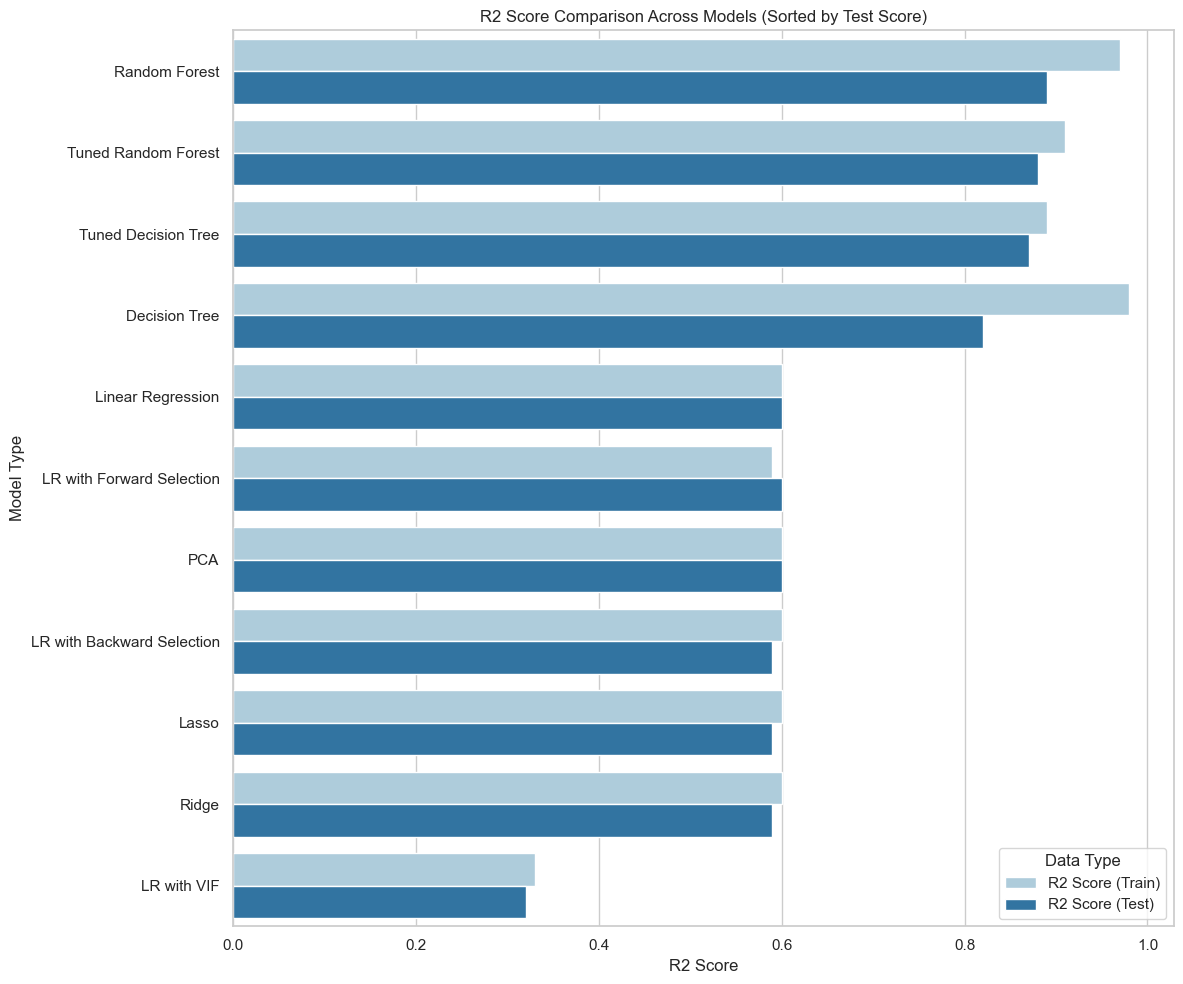

In [89]:
data = {
    "Model": [
        "Linear Regression", "LR with Forward Selection", "LR with Backward Selection",
        "LR with VIF", "PCA", "Lasso", "Ridge", "Decision Tree", "Tuned Decision Tree",
        "Random Forest", "Tuned Random Forest"
    ],
    "R2 Score (Train)": [
        0.60, 0.59, 0.60, 0.33, 0.6, 0.6, 0.6, 0.98, 0.89, 0.97, 0.91
    ],
    "R2 Score (Test)": [
        0.60, 0.6, 0.59, 0.32, 0.6, 0.59, 0.59, 0.82, 0.87, 0.89, 0.88
    ]
}

# Convert the data to a pandas DataFrame
df_models = pd.DataFrame(data)

# Sorting based on 'R2 Score (Test)'
df_models_sorted = df_models.sort_values(by='R2 Score (Test)', ascending=False)

# Reshape the sorted data for seaborn
df_long_sorted = pd.melt(df_models_sorted, id_vars='Model', var_name='Dataset', value_name='R2 Score')

# Create a more creative plot with a different theme and colors
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 10))
sns.barplot(x='R2 Score', y='Model', hue='Dataset', data=df_long_sorted, palette='Paired')
plt.title('R2 Score Comparison Across Models (Sorted by Test Score)')
plt.xlabel('R2 Score')
plt.ylabel('Model Type')
plt.legend(title='Data Type')
plt.tight_layout()
plt.show()